# Search: Solving a Maze Using a Goal-based Agent

Student Name: [Add your name]

## Instructions

Total Points: Undergrads 100 / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a PDF file.


## Introduction

The agent has a map of the maze it is in and the environment is assumed to be **deterministic, discrete, and known.** The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root noteto the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [1]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore the state space may not form proper trees unless cycles are prevented. Therfore, you will need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [2]:
import maze_helper as mh
import numpy as np

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

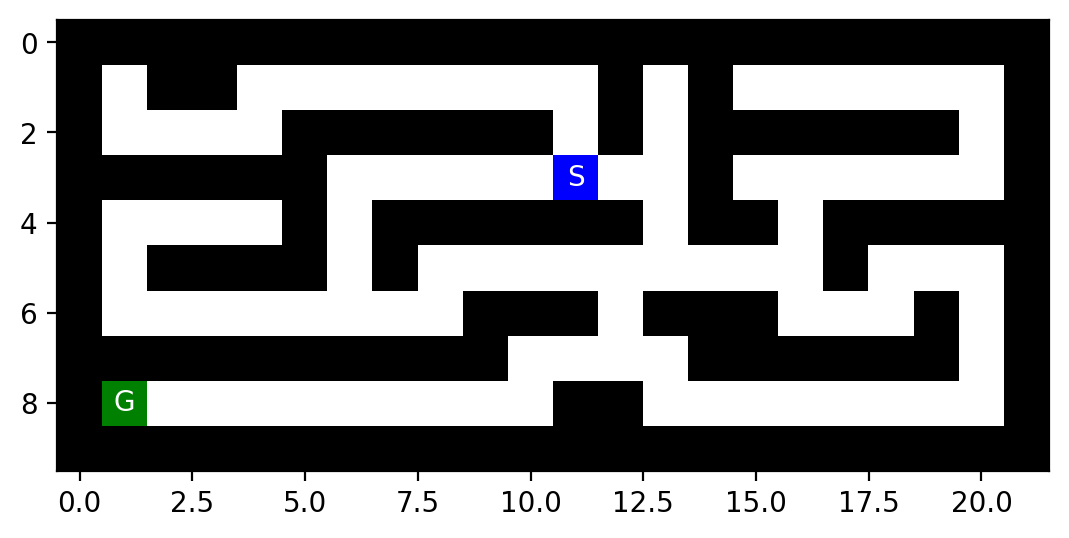

[['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X'
  'X' 'X' 'X' 'X']
 ['X' ' ' 'X' 'X' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X' ' ' 'X' ' ' ' ' ' '
  ' ' ' ' ' ' 'X']
 ['X' ' ' ' ' ' ' ' ' 'X' 'X' 'X' 'X' 'X' 'X' ' ' 'X' ' ' 'X' 'X' 'X' 'X'
  'X' 'X' ' ' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' ' ' ' ' ' ' ' ' ' ' 'S' ' ' ' ' 'X' ' ' ' ' ' '
  ' ' ' ' ' ' 'X']
 ['X' ' ' ' ' ' ' ' ' 'X' ' ' 'X' 'X' 'X' 'X' 'X' 'X' ' ' 'X' 'X' ' ' 'X'
  'X' 'X' 'X' 'X']
 ['X' ' ' 'X' 'X' 'X' 'X' ' ' 'X' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X'
  ' ' ' ' ' ' 'X']
 ['X' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X' 'X' 'X' ' ' 'X' 'X' 'X' ' ' ' '
  ' ' 'X' ' ' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' ' ' ' ' ' ' ' ' 'X' 'X' 'X' 'X'
  'X' 'X' ' ' 'X']
 ['X' 'G' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'X' 'X' ' ' ' ' ' ' ' ' ' '
  ' ' ' ' ' ' 'X']
 ['X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X' 'X'
  'X' 'X' 'X' 'X']]


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

mh.show_maze(maze)
print(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [4]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


Helper function documentation.

In [5]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
        a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).
    
    parse_maze(maze_str)
        Convert a maze as a string into a 2d numpy array
    
    show_maze(maze, fontsize=10)
        Display a (parsed) maze as an image.
    
    welcome()
        Welcome message.

FILE
    /Users/cameronervin/Documents/maze/maze_helper.py




## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [6]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formated professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
4. Document your code. Add a short discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.

**Initial state** - the starting point for the agent within the maze. A coordinate within an nxm matrix.

**Actions** - the agent can either move north, south, east, or west. However, the agent must stay within the domain of the maze matrix. Also, the agent cannot jump over or step on top of barriers or walls. For each action, the agent either adds the new position to the frontier or a list of explored squares.

**Transition model** -

Result(In(X,Y), Go(north)) = In(X-1,Y)

Result(In(X,Y), Go(south)) = In(X+1,Y)

Result(In(X,Y), Go(east)) = In(X,Y-1)

Result(In(X,Y), Go(west)) = In(X,Y+1)

**Goal state** - the agent must reach the goal location. The goal location is a position from the maze that is arbitrarily chosen and stays constant throughout the entire search process. The agent must reach this state using legal actions.

**Path cost** - the path cost is the total number of steps needed to reach the goal state. The fewer number of steps, the lower the path cost.


Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

**𝑛 : state space size** - the state space size for a maze is the area of the maze nxm. To find the state space size for a maze, find the area.

**𝑑: depth of the optimal solution** - the minimum number of steps from the initial state to the goal state.

**𝑚: maximum depth of tree** - the maximum length of any path from the initial state to either the goal state or a stopping point/leaf node.

**𝑏: maximum branching factor** - build the search tree of the maze. Find the maximum number of children a parent has.


## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information in the tree created during search, and use the `reached` and `frontier` data structures.
* DSF can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure and by releasing the memory for nodes that are not needed anymore.
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. Remember, that DSF is incomplete if cycles cannot be prevented. You will see in your experiments that open spaces are a problem.

In [7]:
# directions dictionary
directions = {
    'North':(-1, 0),
    'East':( 0, 1),
    'South':( 1, 0),
    'West':( 0,-1)
}

In [8]:
# expand function
import random

# input maze and current node, rand for DFS
def expand(maze, node, rand=False):

  # ititialize position as current node position
  position = node.pos

  # children dictionary to return child of node
  children = {}

  # rand if randomized direction dict
  if rand:
      
      # create copy of directions
      dir_copy = list(directions.items())

      #randomize
      random.shuffle(dir_copy)

      #create randomized dict
      dir_rand = dict(dir_copy)

      for dir,pos in dir_rand.items():
        new_pos = pos[0]+position[0], pos[1]+position[1]
        if mh.look(maze, new_pos) != 'X':
          children[dir] = new_pos
  else:
    
    # if not randomized expand
    # for direction and position in directions dict
    for dir,pos in directions.items():
        
        # create new position from loop
        new_pos = pos[0]+position[0], pos[1]+position[1]

        # if not a wall add to children
        if mh.look(maze, new_pos) != 'X':
          children[dir] = new_pos

  # return children
  return children

In [9]:
# add path to maze
def add_path_type(maze, path):

    # check if final_path in maze
    if 'final_path' in path.keys():

        # for pos in when key final_path
        for pos in path['final_path']:

            # if the position is space
            if mh.look(maze,[pos[0],pos[1]]) == ' ':

                # change maze position to P for path
                maze[pos[0],pos[1]] = 'P'

    if 'frontier' in path.keys():
        for pos in path['frontier']:
            if mh.look(maze,[pos[0],pos[1]]) == ' ':
                maze[pos[0],pos[1]] = 'F'

    if 'reached' in path.keys():
        for pos in path['reached']:
            if mh.look(maze,[pos[0],pos[1]]) == ' ':
                maze[pos[0],pos[1]] = '.'


In [10]:
# breadth first search
# input maze, animate boolean, output boolean, and print boolean
def BFS(maze, anim = False, output = False, verb = False, rand = True):

  # use maze helper to find location of starting position
  initial_state = mh.find_pos(maze, what = "S")

  # use node class to initialize root node
  node = Node(initial_state, parent = None, action = None, cost = 0)

  # initialize frontier and reached data structures
  # frontier is a FIFO queue
  frontier = [node]
  # reached is a dictionary with the node position as the key and node as the value
  reached = {node.pos : node}

  # values for table output
  num_exp = 0
  max_depth = 0
  max_in_mem = 0
  max_front = 0

  # if start at goal position, finish
  if mh.look(maze, initial_state) == 'G':
    path = node.get_path_from_root()
    if verb:
      p = node.get_path_from_root()
      path = [n.pos for n in p]
      return print( f"path : {path}")
    else:
      return

  # store path data to animate
  animate_path = []

  # loop while the frontier length is greather than 1, else return error
  while not len(frontier) < 1:

    # pop first node from the frontier
    node = frontier.pop(0)

    # use expand function to find the children of each node
    for child in expand(maze, node, rand).items():

      # action for each child
      action = child[0]

      # position for each child
      child_pos = child[1]

      # create child node
      s = Node(child_pos, node, action, cost=node.cost+1)

      # add to expand count
      num_exp += 1

      p = s.get_path_from_root()
      path = [n.pos for n in p]

      # find max tree depth
      if len(path) > max_depth:
        max_depth = len(path)
      
      # if child reaches goal position, finish
      if mh.look(maze, child_pos) == 'G':
        cost = node.cost
        if output:
          return cost, num_exp, max_depth, max_in_mem, max_front
        elif verb:
          return print( f"path : {path} \n"
            f"actions : {[n.action for n in p]} \n"
            f"cost : {cost}")
        else:
          return

      # if child position is not in the reached data structure, add to reached and frontier
      if child_pos not in reached.keys():
        reached[child_pos] = (s)
        frontier.append(s)

        # find max number of ndoes in memory
        if (len(reached.keys()) + len([n.pos for n in frontier])) > max_in_mem:
          max_in_mem = len(reached.keys()) + len([n.pos for n in frontier])

        # find max frontier size
        if len([n.pos for n in frontier]) > max_front:
          max_front = len([n.pos for n in frontier])
    
    # call add path type if anim is True
    if anim:
      path = node.get_path_from_root()
      animate_path.append(add_path_type(maze, {
              "final_path" : [n.pos for n in path],
              "frontier" : [n.pos for n in frontier],
              "reached" : reached.keys()
          }))
      # print output
      mh.show_maze(maze)
      
      
  return print('Error: Empty Frontier')


In [11]:
f = open("small_maze.txt", "r")

maze_str = f.read()
maze = mh.parse_maze(maze_str)

result = BFS(maze, verb = True)

path : [(3, 11), (3, 12), (3, 13), (4, 13), (5, 13), (5, 12), (6, 12), (7, 12), (7, 11), (7, 10), (8, 10), (8, 9), (8, 8), (8, 7), (8, 6), (8, 5), (8, 4), (8, 3), (8, 2), (8, 1)] 
actions : [None, 'East', 'East', 'South', 'South', 'West', 'South', 'South', 'West', 'West', 'South', 'West', 'West', 'West', 'West', 'West', 'West', 'West', 'West', 'West'] 
cost : 18


In [12]:
# find average run times for BFS for 
import time
from statistics import mean
from pprint import pprint

# list of all read in mazes
mazes = ["small_maze.txt", "medium_maze.txt", "large_maze.txt", "open_maze.txt", "wall_maze.txt", "loops_maze.txt", "empty_maze.txt", "empty_2_maze.txt"]
times = {}
avg_time = []

# number of runs for avg time
runs = 100

# loop through mazes
for i in mazes:
    f = open(i, "r")
    maze_str = f.read()
    maze = mh.parse_maze(maze_str)

    # loop through number of runs
    for j in range(runs):
        start = time.time()
        result = BFS(maze)
        end = time.time()
        difference = end-start
        avg_time.append(difference)
    time_mean = str(round(mean(avg_time), 6))
    times[i] = (time_mean + ' s')

pprint(times)


{'empty_2_maze.txt': '0.007241 s',
 'empty_maze.txt': '0.008041 s',
 'large_maze.txt': '0.010708 s',
 'loops_maze.txt': '0.009107 s',
 'medium_maze.txt': '0.003496 s',
 'open_maze.txt': '0.013021 s',
 'small_maze.txt': '0.001386 s',
 'wall_maze.txt': '0.010706 s'}


In [13]:
# is_cycle funtion returns boolean if search creates cycle
def is_cycle(node):

  # reached nodes from node path minus the most recent node
  reached_nodes = node.get_path_from_root()[:-1]
  
  # loop through nodes in reached_nodes
  for n in reached_nodes:

    # if node position is equal to current node position
    if n.pos == node.pos:

      # return true meaning cycle
      return True
    
  # if not cycle return false
  return False

In [14]:
# depth first search takes input of length, anim, output, verb, rand
# l is for iterative deepening search
# rand boolean randomizes the order of directions dict
def DFS(maze, l = None, anim = False, output = False, verb = False, rand = True):
  initial_state = mh.find_pos(maze, what = "S")

  node = Node(initial_state, parent = None, action = None, cost = 0)

  # no reached data structure for DFS
  # frontier is a LIFO queue
  frontier = [node]
  result = 'failure'

  num_exp = 0
  max_depth = 0
  max_in_mem = 0
  max_front = 0

  # depth count for IDS
  depth_count = 0
  animate_path = []

  if mh.look(maze, initial_state) == 'G':
    path = node.get_path_from_root()
    if verb:
      p = node.get_path_from_root()
      path = [n.pos for n in p]
      return print( f"path : {path}")
    else:
      return

  while not len(frontier) < 1:

    # pop last node in queue
    node = frontier.pop()

    if mh.look(maze, node.pos) == 'G':
      cost = node.cost
      if output:
        return cost, num_exp, max_depth, max_in_mem, max_front
      if verb:
        return print( f"path : {path} \n"
            f"actions : {[n.action for n in p]} \n"
            f"cost : {cost}")
      else:
        return

    # if l is initialized
    if l != None:

      # for each loop add one to depth_count
      depth_count += 1

      # if depth count reaches l, stop
      if depth_count >= l:
        return result

    # check if new node is a cycle
    if (is_cycle(node) == False):

      # create list of nodes if not cycle to see if node already added
      child_nodes = []

      # if no cycle, expand
      for child in expand(maze, node, rand).items():
        action = child[0]
        child_pos = child[1]
        s = Node(child_pos, node, action, cost=node.cost+1)

        num_exp += 1

        p = s.get_path_from_root()
        path = [n.pos for n in p]

        # add choldren to child_nodes
        child_nodes.append(s)

      # create list of positions of new children
      children_pos = [n.pos for n in child_nodes]

      # add children if not already in frontier
      frontier = [n for n in frontier if n.pos not in children_pos] + child_nodes

      if len(path) > max_depth:
          max_depth = len(path)

      if len([n.pos for n in frontier]) > max_in_mem:
        max_in_mem = len([n.pos for n in frontier])
      
      if len([n.pos for n in frontier]) > max_front:
          max_front = len([n.pos for n in frontier])

    if anim:
      animate_path.append(add_path_type(maze, {
              "final_path" : [n.pos for n in node.get_path_from_root()],
              "frontier" : [n.pos for n in frontier]
          }))
      mh.show_maze(maze)

  return result

In [15]:
#"small_maze.txt", "medium_maze.txt", "large_maze.txt", "open_maze.txt", "wall_maze.txt", "loops_maze.txt", "empty_maze.txt", "empty_2_maze.txt"
f = open("open_maze.txt", "r")

maze_str = f.read()
maze = mh.parse_maze(maze_str)

result = DFS(maze, verb = True)

path : [(1, 35), (2, 35), (2, 34), (2, 33), (3, 33), (3, 34), (4, 34), (4, 33), (4, 32), (4, 31), (4, 30), (4, 29), (5, 29), (5, 28), (5, 27), (6, 27), (6, 26), (6, 25), (7, 25), (8, 25), (8, 26), (8, 27), (8, 28), (9, 28), (9, 29), (8, 29), (7, 29), (7, 30), (7, 31), (7, 32), (6, 32), (6, 33), (5, 33), (5, 34), (5, 35), (6, 35), (7, 35), (8, 35), (8, 34), (9, 34), (9, 33), (10, 33), (10, 32), (11, 32), (11, 31), (12, 31), (12, 32), (12, 33), (11, 33), (11, 34), (11, 35), (12, 35), (13, 35), (13, 34), (13, 33), (13, 32), (13, 31), (13, 30), (12, 30), (12, 29), (13, 29), (13, 28), (12, 28), (11, 28), (11, 29), (11, 30), (10, 30), (10, 29), (10, 28), (10, 27), (10, 26), (11, 26), (11, 27), (12, 27), (13, 27), (13, 26), (12, 26), (12, 25), (12, 24), (12, 23), (12, 22), (11, 22), (10, 22), (10, 23), (11, 23), (11, 24), (11, 25), (10, 25), (9, 25), (9, 24), (8, 24), (7, 24), (7, 23), (7, 22), (8, 22), (8, 23), (9, 23), (9, 22), (9, 21), (8, 21), (7, 21), (6, 21), (5, 21), (4, 21), (3, 21), 

In [16]:
# find average run times for DFS
import time
from statistics import mean
from pprint import pprint

# list of all read in mazes
mazes = ["small_maze.txt", "medium_maze.txt", "large_maze.txt", "open_maze.txt", "wall_maze.txt", "loops_maze.txt", "empty_maze.txt", "empty_2_maze.txt"]
times = {}
avg_time = []

# number of runs for avg time
runs = 100

# loop through mazes
for i in mazes:
    f = open(i, "r")
    maze_str = f.read()
    maze = mh.parse_maze(maze_str)

    # loop through number of runs
    for j in range(runs):
        start = time.time()
        result = DFS(maze)
        end = time.time()
        difference = end-start
        avg_time.append(difference)
    time_mean = str(round(mean(avg_time), 6))
    times[i] = (time_mean + ' s')

pprint(times)


{'empty_2_maze.txt': '0.016449 s',
 'empty_maze.txt': '0.018443 s',
 'large_maze.txt': '0.018367 s',
 'loops_maze.txt': '0.021083 s',
 'medium_maze.txt': '0.008434 s',
 'open_maze.txt': '0.030676 s',
 'small_maze.txt': '0.001484 s',
 'wall_maze.txt': '0.024977 s'}


How does BFS and DFS deal with loops (cycles)?

BFS and DFS deal with loops differently. BFS uses a reached data structure which stores the nodes that have been expanded to. Therefore, BFS avoids any loops or cycles. DFS on the other hand does not have a reached data structure. As a result, we must check for cycles using the is_cycle function. The is_cycle function returns true or false allowing the program to continue. Additionally, we must check the children nodes of a node again after we have ran the is_cycle function to remove any duplicated nodes.

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of your implementations?

BFS is both complete and optimal since it is guaranteed to find a solution and that solution will be optimal. The time and space complexity of BFS is O(b^d). DFS is complete since the search space of a maze is finite. Additionally, DFS is not optimal since it just returns the first solution it finds. The time complexity of DFS is O(b^m), and the space complexity is O(bm). This is why BFS is not efficient in large search spaces compared to DFS.

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

In [17]:
# heuristic - use manhattan since it dominates euclidean
# adjusted from https://www.statology.org/manhattan-distance-python/
from math import sqrt

def manhattan(current_pos, goal_pos):
    return sum(abs(pos0-pos1) for pos0, pos1 in zip(current_pos,goal_pos))

In [18]:
# greedy best first search
import pandas as pd

def GBFS(maze, anim = False, output = False, verb = False, rand = True):
  initial_state = mh.find_pos(maze, what = "S")

  # goal state needed for informed search
  goal_state = mh.find_pos(maze, what = "G")

  node = Node(initial_state, parent = None, action = None, cost = 0)

  frontier = [node]
  reached = {node.pos : node}

  num_exp = 0
  max_depth = 0
  max_in_mem = 0
  max_front = 0

  if mh.look(maze, initial_state) == 'G':
    path = node.get_path_from_root()
    if verb:
      p = node.get_path_from_root()
      path = [n.pos for n in p]
      return print( f"path : {path}")
    else:
      return

  animate_path = []

  while not len(frontier) < 1:

    # create list of heuristics for each node in frontier
    frontier_pos_heuristic = []

    # add to heuristic list for each node in frontier
    for n in frontier:

      # call manhattan function with node position and goal_state to find heuristic
      frontier_pos_heuristic.append(manhattan(n.pos, goal_state))
      
    # adjusted from https://www.geeksforgeeks.org/python-maximum-minimum-elements-position-list/#
    node = frontier.pop(pd.Series(frontier_pos_heuristic).idxmin())

    p = node.get_path_from_root()
    path = [n.pos for n in p]

    if len(path) > max_depth:
        max_depth = len(path)

    if mh.look(maze, node.pos) == 'G':
      cost = node.cost
      if output:
        return cost, num_exp, max_depth, max_in_mem, max_front
      if verb:
        return print( f"path : {path} \n"
            f"actions : {[n.action for n in p]} \n"
            f"cost : {cost}")
      else:
        return

    for child in expand(maze, node, rand).items():
      action = child[0]
      child_pos = child[1]
      s = Node(child_pos, node, action, cost=node.cost+1)

      num_exp += 1

      # with GBFS add to reached if not in reached or if the cost of the node is less than the cost of child_pos in reached
      if child_pos not in reached.keys() or s.cost < reached[child_pos].cost:
        reached[child_pos] = (s)
        frontier.append(s)

        if (len(reached.keys()) + len([n.pos for n in frontier])) > max_in_mem:
          max_in_mem = len(reached.keys()) + len([n.pos for n in frontier])

        if len([n.pos for n in frontier]) > max_front:
          max_front = len([n.pos for n in frontier])


    if anim:
      path = node.get_path_from_root()
      animate_path.append(add_path_type(maze, {
              "final_path" : [n.pos for n in path],
              "frontier" : [n.pos for n in frontier_pos_heuristic],
              "reached" : reached.keys()
          }))
      mh.show_maze(maze)

  return 'failure'

In [19]:
#"small_maze.txt", "medium_maze.txt", "large_maze.txt", "open_maze.txt", "wall_maze.txt", "loops_maze.txt", "empty_maze.txt", "empty_2_maze.txt"
f = open("small_maze.txt", "r")

maze_str = f.read()
maze = mh.parse_maze(maze_str)

result = GBFS(maze, verb = True)

path : [(3, 11), (3, 10), (3, 9), (3, 8), (3, 7), (3, 6), (4, 6), (5, 6), (6, 6), (6, 7), (6, 8), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (6, 12), (7, 12), (7, 11), (7, 10), (8, 10), (8, 9), (8, 8), (8, 7), (8, 6), (8, 5), (8, 4), (8, 3), (8, 2), (8, 1)] 
actions : [None, 'West', 'West', 'West', 'West', 'West', 'South', 'South', 'South', 'East', 'East', 'North', 'East', 'East', 'East', 'East', 'South', 'South', 'West', 'West', 'South', 'West', 'West', 'West', 'West', 'West', 'West', 'West', 'West', 'West'] 
cost : 29


In [20]:
# find average run times for GBFS
import time
from statistics import mean
from pprint import pprint

# list of all read in mazes
mazes = ["small_maze.txt", "medium_maze.txt", "large_maze.txt", "open_maze.txt", "wall_maze.txt", "loops_maze.txt", "empty_maze.txt", "empty_2_maze.txt"]
times = {}
avg_time = []

# number of runs for avg time
runs = 100

# loop through mazes
for i in mazes:
    f = open(i, "r")
    maze_str = f.read()
    maze = mh.parse_maze(maze_str)

    # loop through number of runs
    for j in range(runs):
        start = time.time()
        result = GBFS(maze)
        end = time.time()
        difference = end-start
        avg_time.append(difference)
    time_mean = str(round(mean(avg_time), 6))
    times[i] = (time_mean + ' s')

pprint(times)


{'empty_2_maze.txt': '0.008852 s',
 'empty_maze.txt': '0.009943 s',
 'large_maze.txt': '0.016078 s',
 'loops_maze.txt': '0.011397 s',
 'medium_maze.txt': '0.005555 s',
 'open_maze.txt': '0.015327 s',
 'small_maze.txt': '0.002842 s',
 'wall_maze.txt': '0.012592 s'}


In [21]:
# astar search
def astar(maze, anim = False, output = False, verb = False, rand = True):
  initial_state = mh.find_pos(maze, what = "S")
  goal_state = mh.find_pos(maze, what = "G")

  node = Node(initial_state, parent = None, action = None, cost = 0)

  frontier = [node]
  reached = {node.pos : node}

  num_exp = 0
  max_depth = 0
  max_in_mem = 0
  max_front = 0

  if mh.look(maze, initial_state) == 'G':
    path = node.get_path_from_root()
    if verb:
      p = node.get_path_from_root()
      path = [n.pos for n in p]
      return print( f"path : {path}")
    else:
      return

  animate_path = []

  while not len(frontier) < 1:
    frontier_pos_heuristic = []
    for n in frontier:

      # add node cost to manhattan function to find new heuristic
      frontier_pos_heuristic.append(manhattan(n.pos, goal_state) + n.cost)

    node = frontier.pop(pd.Series(frontier_pos_heuristic).idxmin())

    p = node.get_path_from_root()
    path = [n.pos for n in p]

    if len(path) > max_depth:
      max_depth = len(path)

    if mh.look(maze, node.pos) == 'G':
      cost = node.cost
      if output:
        return cost, num_exp, max_depth, max_in_mem, max_front
      if verb:
        return print( f"path : {path} \n"
            f"actions : {[n.action for n in p]} \n"
            f"cost : {cost}")
      else:
        return

    for child in expand(maze, node, rand).items():
      action = child[0]
      child_pos = child[1]
      s = Node(child_pos, node, action, cost=node.cost+1)

      num_exp += 1

      if child_pos not in reached.keys() or s.cost < reached[child_pos].cost:
        reached[child_pos] = (s)
        frontier.append(s)

        if (len(reached.keys()) + len([n.pos for n in frontier])) > max_in_mem:
          max_in_mem = len(reached.keys()) + len([n.pos for n in frontier])

        if len([n.pos for n in frontier]) > max_front:
          max_front = len([n.pos for n in frontier])


    if anim:
      path = node.get_path_from_root()
      animate_path.append(add_path_type(maze, {
              "final_path" : [n.pos for n in path],
              "frontier" : [n.pos for n in frontier_pos_heuristic],
              "reached" : reached.keys()
          }))
      mh.show_maze(maze)

  return 'failure'

In [22]:
#"small_maze.txt", "medium_maze.txt", "large_maze.txt", "open_maze.txt", "wall_maze.txt", "loops_maze.txt", "empty_maze.txt", "empty_2_maze.txt"
f = open("small_maze.txt", "r")

maze_str = f.read()
maze = mh.parse_maze(maze_str)

result = astar(maze, verb = True)

path : [(3, 11), (3, 12), (3, 13), (4, 13), (5, 13), (5, 12), (6, 12), (7, 12), (7, 11), (7, 10), (8, 10), (8, 9), (8, 8), (8, 7), (8, 6), (8, 5), (8, 4), (8, 3), (8, 2), (8, 1)] 
actions : [None, 'East', 'East', 'South', 'South', 'West', 'South', 'South', 'West', 'West', 'South', 'West', 'West', 'West', 'West', 'West', 'West', 'West', 'West', 'West'] 
cost : 19


In [23]:
# find average run times for astar
import time
from statistics import mean
from pprint import pprint

# list of all read in mazes
mazes = ["small_maze.txt", "medium_maze.txt", "large_maze.txt", "open_maze.txt", "wall_maze.txt", "loops_maze.txt", "empty_maze.txt", "empty_2_maze.txt"]
times = {}
avg_time = []

# number of runs for avg time
runs = 100

# loop through mazes
for i in mazes:
    f = open(i, "r")
    maze_str = f.read()
    maze = mh.parse_maze(maze_str)

    # loop through number of runs
    for j in range(runs):
        start = time.time()
        result = astar(maze)
        end = time.time()
        difference = end-start
        avg_time.append(difference)
    time_mean = str(round(mean(avg_time), 6))
    times[i] = (time_mean + ' s')

pprint(times)


{'empty_2_maze.txt': '0.016014 s',
 'empty_maze.txt': '0.017476 s',
 'large_maze.txt': '0.020893 s',
 'loops_maze.txt': '0.019428 s',
 'medium_maze.txt': '0.009904 s',
 'open_maze.txt': '0.02691 s',
 'small_maze.txt': '0.003876 s',
 'wall_maze.txt': '0.022537 s'}


Are your implementations complete and optimal? What is the time and space complexity?

GBFS is complete like BFS but it is not optimal. Time and space complexity for GBFS are both O(b^m) for worst case scenario and O(bm) for best case scenario. A* is both complete and optimal. Also, the time and space complexity of A* are always the same O(b^d) for the number of nodes that the algorithm reaches. The better the heuristic, the fewer nodes the search expands to.

## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

__Small Maze__

In [24]:
BFS_avg = [0,0,0,0,0]
DFS_avg = [0,0,0,0,0]
GBFS_avg = [0,0,0,0,0]
astar_avg = [0,0,0,0,0]

small_BFS = []
small_DFS = []
small_GBFS = []
small_astar = []

small_table_data = {}

# number of runs for avg time
runs = 100

f = open("small_maze.txt", "r")
maze_str = f.read()
maze = mh.parse_maze(maze_str)

# loop through number of runs
# breadth first search
for i in range(runs):
    result = BFS(maze, output = True)
    small_BFS.append(result)
    for j in range(len(BFS_avg)):
        BFS_avg[j] += result[j]

# add average to small table data for search type
for j in range(len(BFS_avg)):
    BFS_avg[j] = BFS_avg[j] /runs

small_table_data['BFS'] = BFS_avg

# depth first search
for i in range(runs):
    result = DFS(maze, output = True)
    small_DFS.append(result)
    for j in range(len(DFS_avg)):
        DFS_avg[j] += result[j]

for j in range(len(DFS_avg)):
    DFS_avg[j] = DFS_avg[j] /runs

small_table_data['DFS'] = DFS_avg

# greedy best first search
for i in range(runs):
    result = GBFS(maze, output = True)
    small_GBFS.append(result)
    for j in range(len(GBFS_avg)):
        GBFS_avg[j] += result[j]

for j in range(len(GBFS_avg)):
    GBFS_avg[j] = GBFS_avg[j] /runs

small_table_data['GBFS'] = GBFS_avg

# astar search
for i in range(runs):
    result = astar(maze, output = True)
    small_astar.append(result)
    for j in range(len(astar_avg)):
        astar_avg[j] += result[j]

for j in range(len(astar_avg)):
    astar_avg[j] = astar_avg[j] /runs

small_table_data['A*'] = astar_avg

df = pd.DataFrame(small_table_data)
df.index = ("path_cost", "#_of_nodes_expanded", "max_tree_depth", "max_#_of_nodes_in_memory","max_frontier_size")
df = pd.DataFrame.transpose(df)
df

,path_cost,#_of_nodes_expanded,max_tree_depth,max_#_of_nodes_in_memory,max_frontier_size
BFS,18.00,183.99,20.00,94.20,8.72
DFS,33.32,122.21,40.16,25.05,25.05
GBFS,29.00,81.00,30.00,49.00,5.00
A*,19.00,112.00,20.00,66.00,8.00


__Medium Maze__

In [25]:
BFS_avg = [0,0,0,0,0]
DFS_avg = [0,0,0,0,0]
GBFS_avg = [0,0,0,0,0]
astar_avg = [0,0,0,0,0]

med_BFS = []
med_DFS = []
med_GBFS = []
med_astar = []

medium_table_data = {}

# number of runs for avg time
runs = 100

f = open("medium_maze.txt", "r")
maze_str = f.read()
maze = mh.parse_maze(maze_str)

# loop through number of runs
# breadth first search
for i in range(runs):
    result = BFS(maze, output = True)
    med_BFS.append(result)
    for j in range(len(BFS_avg)):
        BFS_avg[j] += result[j]

# add average to small table data for search type
for j in range(len(BFS_avg)):
    BFS_avg[j] = BFS_avg[j] /runs

medium_table_data['BFS'] = BFS_avg

# depth first search
for i in range(runs):
    result = DFS(maze, output = True)
    med_DFS.append(result)
    for j in range(len(DFS_avg)):
        DFS_avg[j] += result[j]

for j in range(len(DFS_avg)):
    DFS_avg[j] = DFS_avg[j] /runs

medium_table_data['DFS'] = DFS_avg

# greedy best first search
for i in range(runs):
    result = GBFS(maze, output = True)
    med_GBFS.append(result)
    for j in range(len(GBFS_avg)):
        GBFS_avg[j] += result[j]

for j in range(len(GBFS_avg)):
    GBFS_avg[j] = GBFS_avg[j] /runs

medium_table_data['GBFS'] = GBFS_avg

# astar search
for i in range(runs):
    result = astar(maze, output = True)
    med_astar.append(result)
    for j in range(len(astar_avg)):
        astar_avg[j] += result[j]

for j in range(len(astar_avg)):
    astar_avg[j] = astar_avg[j] /runs

medium_table_data['A*'] = astar_avg

df = pd.DataFrame(medium_table_data)
df.index = ("path_cost", "#_of_nodes_expanded", "max_tree_depth", "max_#_of_nodes_in_memory","max_frontier_size")
df = pd.DataFrame.transpose(df)
df

,path_cost,#_of_nodes_expanded,max_tree_depth,max_#_of_nodes_in_memory,max_frontier_size
BFS,67.00,545.36,69.00,272.61,8.23
DFS,127.48,417.54,167.31,91.35,91.35
GBFS,117.68,250.72,118.68,135.28,6.24
A*,68.00,455.00,69.00,235.00,8.00


__Large Maze__

In [26]:
BFS_avg = [0,0,0,0,0]
DFS_avg = [0,0,0,0,0]
GBFS_avg = [0,0,0,0,0]
astar_avg = [0,0,0,0,0]

lrg_BFS = []
lrg_DFS = []
lrg_GBFS = []
lrg_astar = []

large_table_data = {}

# number of runs for avg time
runs = 100

f = open("medium_maze.txt", "r")
maze_str = f.read()
maze = mh.parse_maze(maze_str)

# loop through number of runs
# breadth first search
for i in range(runs):
    result = BFS(maze, output = True)
    lrg_BFS.append(result)
    for j in range(len(BFS_avg)):
        BFS_avg[j] += result[j]

# add average to small table data for search type
for j in range(len(BFS_avg)):
    BFS_avg[j] = BFS_avg[j] /runs

large_table_data['BFS'] = BFS_avg

# depth first search
for i in range(runs):
    result = DFS(maze, output = True)
    lrg_DFS.append(result)
    for j in range(len(DFS_avg)):
        DFS_avg[j] += result[j]

for j in range(len(DFS_avg)):
    DFS_avg[j] = DFS_avg[j] /runs

large_table_data['DFS'] = DFS_avg

# greedy best first search
for i in range(runs):
    result = GBFS(maze, output = True)
    lrg_GBFS.append(result)
    for j in range(len(GBFS_avg)):
        GBFS_avg[j] += result[j]

for j in range(len(GBFS_avg)):
    GBFS_avg[j] = GBFS_avg[j] /runs

large_table_data['GBFS'] = GBFS_avg

# astar search
for i in range(runs):
    result = astar(maze, output = True)
    lrg_astar.append(result)
    for j in range(len(astar_avg)):
        astar_avg[j] += result[j]

for j in range(len(astar_avg)):
    astar_avg[j] = astar_avg[j] /runs

large_table_data['A*'] = astar_avg

df = pd.DataFrame(large_table_data)
df.index = ("path_cost", "#_of_nodes_expanded", "max_tree_depth", "max_#_of_nodes_in_memory","max_frontier_size")
df = pd.DataFrame.transpose(df)
df

,path_cost,#_of_nodes_expanded,max_tree_depth,max_#_of_nodes_in_memory,max_frontier_size
BFS,67.00,545.64,69.00,272.65,8.24
DFS,135.00,423.00,173.28,94.52,94.52
GBFS,114.56,244.44,115.56,131.86,6.08
A*,68.00,455.00,69.00,235.00,8.00


__Open Maze__

In [27]:
BFS_avg = [0,0,0,0,0]
DFS_avg = [0,0,0,0,0]
GBFS_avg = [0,0,0,0,0]
astar_avg = [0,0,0,0,0]

open_BFS = []
open_DFS = []
open_GBFS = []
open_astar = []

open_table_data = {}

# number of runs for avg time
runs = 100

f = open("open_maze.txt", "r")
maze_str = f.read()
maze = mh.parse_maze(maze_str)

# loop through number of runs
# breadth first search
for i in range(runs):
    result = BFS(maze, output = True)
    open_BFS.append(result)
    for j in range(len(BFS_avg)):
        BFS_avg[j] += result[j]

# add average to small table data for search type
for j in range(len(BFS_avg)):
    BFS_avg[j] = BFS_avg[j] /runs

open_table_data['BFS'] = BFS_avg

# depth first search
for i in range(runs):
    result = DFS(maze, output = True)
    open_DFS.append(result)
    for j in range(len(DFS_avg)):
        DFS_avg[j] += result[j]

for j in range(len(DFS_avg)):
    DFS_avg[j] = DFS_avg[j] /runs

open_table_data['DFS'] = DFS_avg

# greedy best first search
for i in range(runs):
    result = GBFS(maze, output = True)
    open_GBFS.append(result)
    for j in range(len(GBFS_avg)):
        GBFS_avg[j] += result[j]

for j in range(len(GBFS_avg)):
    GBFS_avg[j] = GBFS_avg[j] /runs

open_table_data['GBFS'] = GBFS_avg

# astar search
for i in range(runs):
    result = astar(maze, output = True)
    open_astar.append(result)
    for j in range(len(astar_avg)):
        astar_avg[j] += result[j]

for j in range(len(astar_avg)):
    astar_avg[j] = astar_avg[j] /runs

open_table_data['A*'] = astar_avg

df = pd.DataFrame(open_table_data)
df.index = ("path_cost", "#_of_nodes_expanded", "max_tree_depth", "max_#_of_nodes_in_memory","max_frontier_size")
df = pd.DataFrame.transpose(df)
df

,path_cost,#_of_nodes_expanded,max_tree_depth,max_#_of_nodes_in_memory,max_frontier_size
BFS,53.00,2508.86,55.00,688.02,25.00
DFS,204.56,1564.77,231.22,195.22,195.22
GBFS,65.24,401.48,66.24,240.59,80.12
A*,54.00,1985.00,55.00,576.00,25.00


__Empty Maze__

In [28]:
BFS_avg = [0,0,0,0,0]
DFS_avg = [0,0,0,0,0]
GBFS_avg = [0,0,0,0,0]
astar_avg = [0,0,0,0,0]

e_BFS = []
e_DFS = []
e_GBFS = []
e_astar = []

empty_table_data = {}

# number of runs for avg time
runs = 100

f = open("empty_maze.txt", "r")
maze_str = f.read()
maze = mh.parse_maze(maze_str)

# loop through number of runs
# breadth first search
for i in range(runs):
    result = BFS(maze, output = True)
    e_BFS.append(result)
    for j in range(len(BFS_avg)):
        BFS_avg[j] += result[j]

# add average to small table data for search type
for j in range(len(BFS_avg)):
    BFS_avg[j] = BFS_avg[j] /runs

empty_table_data['BFS'] = BFS_avg

# depth first search
for i in range(runs):
    result = DFS(maze, output = True)
    e_DFS.append(result)
    for j in range(len(DFS_avg)):
        DFS_avg[j] += result[j]

for j in range(len(DFS_avg)):
    DFS_avg[j] = DFS_avg[j] /runs

empty_table_data['DFS'] = DFS_avg

# greedy best first search
for i in range(runs):
    result = GBFS(maze, output = True)
    e_GBFS.append(result)
    for j in range(len(GBFS_avg)):
        GBFS_avg[j] += result[j]

for j in range(len(GBFS_avg)):
    GBFS_avg[j] = GBFS_avg[j] /runs

empty_table_data['GBFS'] = GBFS_avg

# astar search
for i in range(runs):
    result = astar(maze, output = True)
    e_astar.append(result)
    for j in range(len(astar_avg)):
        astar_avg[j] += result[j]

for j in range(len(astar_avg)):
    astar_avg[j] = astar_avg[j] /runs

empty_table_data['A*'] = astar_avg

df = pd.DataFrame(empty_table_data)
df.index = ("path_cost", "#_of_nodes_expanded", "max_tree_depth", "max_#_of_nodes_in_memory","max_frontier_size")
df = pd.DataFrame.transpose(df)
df

,path_cost,#_of_nodes_expanded,max_tree_depth,max_#_of_nodes_in_memory,max_frontier_size
BFS,13.00,332.27,15.00,99.23,11.99
DFS,44.98,214.80,50.98,51.01,51.01
GBFS,14.00,56.00,15.00,62.16,24.08
A*,14.00,252.00,15.00,125.00,31.00


__Empty Maze 2__

In [29]:
BFS_avg = [0,0,0,0,0]
DFS_avg = [0,0,0,0,0]
GBFS_avg = [0,0,0,0,0]
astar_avg = [0,0,0,0,0]

e2_BFS = []
e2_DFS = []
e2_GBFS = []
e2_astar = []

empty_2_table_data = {}

# number of runs for avg time
runs = 100

f = open("empty_2_maze.txt", "r")
maze_str = f.read()
maze = mh.parse_maze(maze_str)

# loop through number of runs
# breadth first search
for i in range(runs):
    result = BFS(maze, output = True)
    e2_BFS.append(result)
    for j in range(len(BFS_avg)):
        BFS_avg[j] += result[j]

# add average to small table data for search type
for j in range(len(BFS_avg)):
    BFS_avg[j] = BFS_avg[j] /runs

empty_2_table_data['BFS'] = BFS_avg

# depth first search
for i in range(runs):
    result = DFS(maze, output = True)
    e2_DFS.append(result)
    for j in range(len(DFS_avg)):
        DFS_avg[j] += result[j]

for j in range(len(DFS_avg)):
    DFS_avg[j] = DFS_avg[j] /runs

empty_2_table_data['DFS'] = DFS_avg

# greedy best first search
for i in range(runs):
    result = GBFS(maze, output = True)
    e2_GBFS.append(result)
    for j in range(len(GBFS_avg)):
        GBFS_avg[j] += result[j]

for j in range(len(GBFS_avg)):
    GBFS_avg[j] = GBFS_avg[j] /runs

empty_2_table_data['GBFS'] = GBFS_avg

# astar search
for i in range(runs):
    result = astar(maze, output = True)
    e2_astar.append(result)
    for j in range(len(astar_avg)):
        astar_avg[j] += result[j]

for j in range(len(astar_avg)):
    astar_avg[j] = astar_avg[j] /runs

empty_2_table_data['A*'] = astar_avg

df = pd.DataFrame(empty_2_table_data)
df.index = ("path_cost", "#_of_nodes_expanded", "max_tree_depth", "max_#_of_nodes_in_memory","max_frontier_size")
df = pd.DataFrame.transpose(df)
df

,path_cost,#_of_nodes_expanded,max_tree_depth,max_#_of_nodes_in_memory,max_frontier_size
BFS,13.00,332.12,15.00,99.34,11.99
DFS,45.96,215.66,51.31,51.65,51.65
GBFS,14.00,56.00,15.00,63.78,24.89
A*,14.00,252.00,15.00,125.00,31.00


__Wall Maze__

In [30]:
BFS_avg = [0,0,0,0,0]
DFS_avg = [0,0,0,0,0]
GBFS_avg = [0,0,0,0,0]
astar_avg = [0,0,0,0,0]

wall_BFS = []
wall_DFS = []
wall_GBFS = []
wall_astar = []

wall_table_data = {}

# number of runs for avg time
runs = 100

f = open("wall_maze.txt", "r")
maze_str = f.read()
maze = mh.parse_maze(maze_str)

# loop through number of runs
# breadth first search
for i in range(runs):
    result = BFS(maze, output = True)
    wall_BFS.append(result)
    for j in range(len(BFS_avg)):
        BFS_avg[j] += result[j]

# add average to small table data for search type
for j in range(len(BFS_avg)):
    BFS_avg[j] = BFS_avg[j] /runs

wall_table_data['BFS'] = BFS_avg

# depth first search
for i in range(runs):
    result = DFS(maze, output = True)
    wall_DFS.append(result)
    for j in range(len(DFS_avg)):
        DFS_avg[j] += result[j]

for j in range(len(DFS_avg)):
    DFS_avg[j] = DFS_avg[j] /runs

wall_table_data['DFS'] = DFS_avg

# greedy best first search
for i in range(runs):
    result = GBFS(maze, output = True)
    wall_GBFS.append(result)
    for j in range(len(GBFS_avg)):
        GBFS_avg[j] += result[j]

for j in range(len(GBFS_avg)):
    GBFS_avg[j] = GBFS_avg[j] /runs

wall_table_data['GBFS'] = GBFS_avg

# astar search
for i in range(runs):
    result = astar(maze, output = True)
    wall_astar.append(result)
    for j in range(len(astar_avg)):
        astar_avg[j] += result[j]

for j in range(len(astar_avg)):
    astar_avg[j] = astar_avg[j] /runs

wall_table_data['A*'] = astar_avg

df = pd.DataFrame(wall_table_data)
df.index = ("path_cost", "#_of_nodes_expanded", "max_tree_depth", "max_#_of_nodes_in_memory","max_frontier_size")
df = pd.DataFrame.transpose(df)
df

,path_cost,#_of_nodes_expanded,max_tree_depth,max_#_of_nodes_in_memory,max_frontier_size
BFS,13.00,289.14,15.00,92.00,9.77
DFS,42.24,189.07,47.46,44.11,44.11
GBFS,14.82,73.90,15.82,70.29,25.74
A*,14.00,208.00,15.00,118.00,31.00


__Loops Maze__

In [31]:
BFS_avg = [0,0,0,0,0]
DFS_avg = [0,0,0,0,0]
GBFS_avg = [0,0,0,0,0]
astar_avg = [0,0,0,0,0]

l_BFS = []
l_DFS = []
l_GBFS = []
l_astar = []

loops_table_data = {}

# number of runs for avg time
runs = 100

f = open("loops_maze.txt", "r")
maze_str = f.read()
maze = mh.parse_maze(maze_str)

# loop through number of runs
# breadth first search
for i in range(runs):
    result = BFS(maze, output = True)
    l_BFS.append(result)
    for j in range(len(BFS_avg)):
        BFS_avg[j] += result[j]

# add average to small table data for search type
for j in range(len(BFS_avg)):
    BFS_avg[j] = BFS_avg[j] /runs

loops_table_data['BFS'] = BFS_avg

# depth first search
for i in range(runs):
    result = DFS(maze, output = True)
    l_DFS.append(result)
    for j in range(len(DFS_avg)):
        DFS_avg[j] += result[j]

for j in range(len(DFS_avg)):
    DFS_avg[j] = DFS_avg[j] /runs

loops_table_data['DFS'] = DFS_avg

# greedy best first search
for i in range(runs):
    result = GBFS(maze, output = True)
    l_GBFS.append(result)
    for j in range(len(GBFS_avg)):
        GBFS_avg[j] += result[j]

for j in range(len(GBFS_avg)):
    GBFS_avg[j] = GBFS_avg[j] /runs

loops_table_data['GBFS'] = GBFS_avg

# astar search
for i in range(runs):
    result = astar(maze, output = True)
    l_astar.append(result)
    for j in range(len(astar_avg)):
        astar_avg[j] += result[j]

for j in range(len(astar_avg)):
    astar_avg[j] = astar_avg[j] /runs

loops_table_data['A*'] = astar_avg

df = pd.DataFrame(loops_table_data)
df.index = ("path_cost", "#_of_nodes_expanded", "max_tree_depth", "max_#_of_nodes_in_memory","max_frontier_size")
df = pd.DataFrame.transpose(df)
df

,path_cost,#_of_nodes_expanded,max_tree_depth,max_#_of_nodes_in_memory,max_frontier_size
BFS,22.0,180.85,24.0,73.03,7.84
DFS,38.0,132.41,40.2,27.84,27.84
GBFS,23.0,217.64,24.0,70.04,9.97
A*,23.0,159.00,24.0,67.00,5.93


Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

In [32]:
import matplotlib.pyplot as plt

***Due to the large variation in data, I chose to use boxplots to show the distribution of the search methods depending on maze. Additionally, I only visualized cost and number of nodes expanded to give an idea of algorithm performance.***

**Small Maze**

In [33]:
bfs = []
dfs = []
gbfs = []
astr = []

# cost
for i in range(runs):
    bfs.append(small_BFS[i][0])
    dfs.append(small_DFS[i][0])
    gbfs.append(small_GBFS[i][0])
    astr.append(small_astar[i][0])

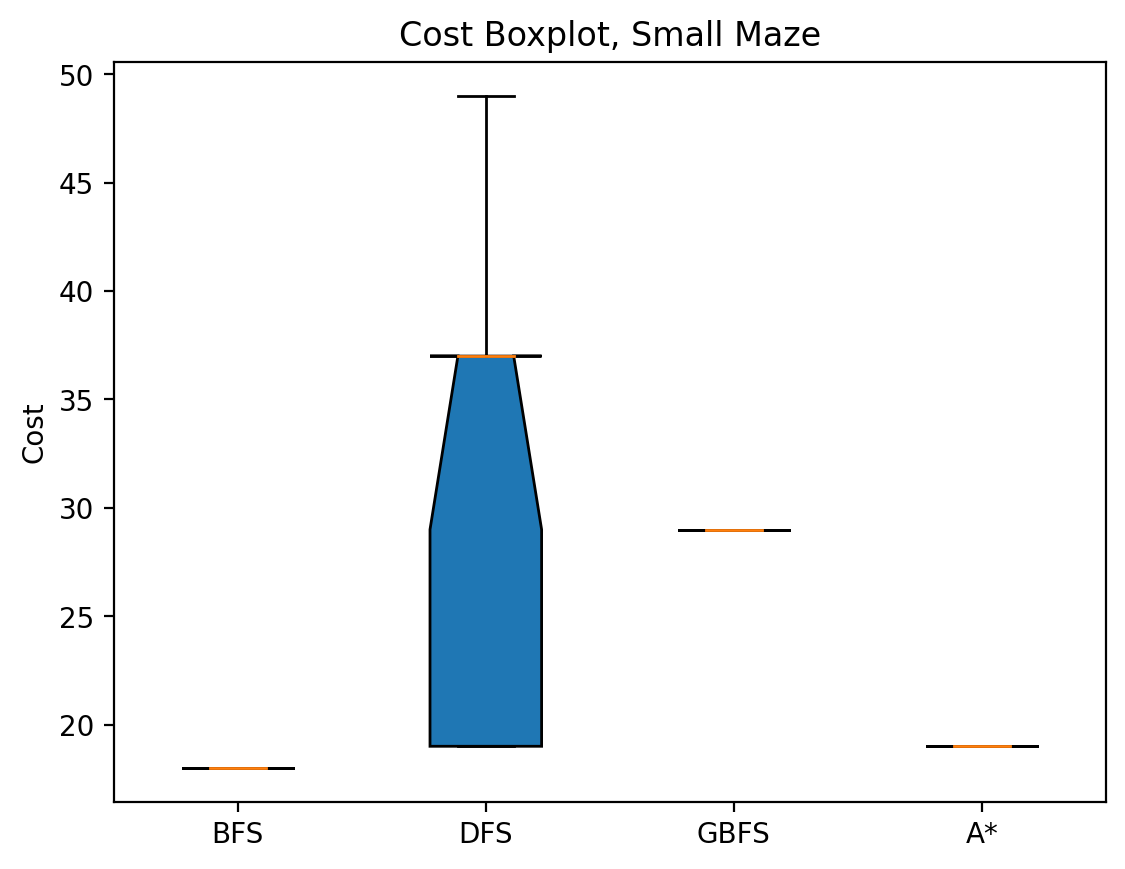

In [34]:
bplot = plt.boxplot(([bfs, dfs, gbfs, astr]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ['BFS','DFS','GBFS','A*'])  # will be used to label x-ticks
plt.ylabel("Cost")
plt.title("Cost Boxplot, Small Maze")
plt.show()

In [35]:
bfs = []
dfs = []
gbfs = []
astr = []

# Number of Expanded Nodes
for i in range(runs):
    bfs.append(small_BFS[i][1])
    dfs.append(small_DFS[i][1])
    gbfs.append(small_GBFS[i][1])
    astr.append(small_astar[i][1])

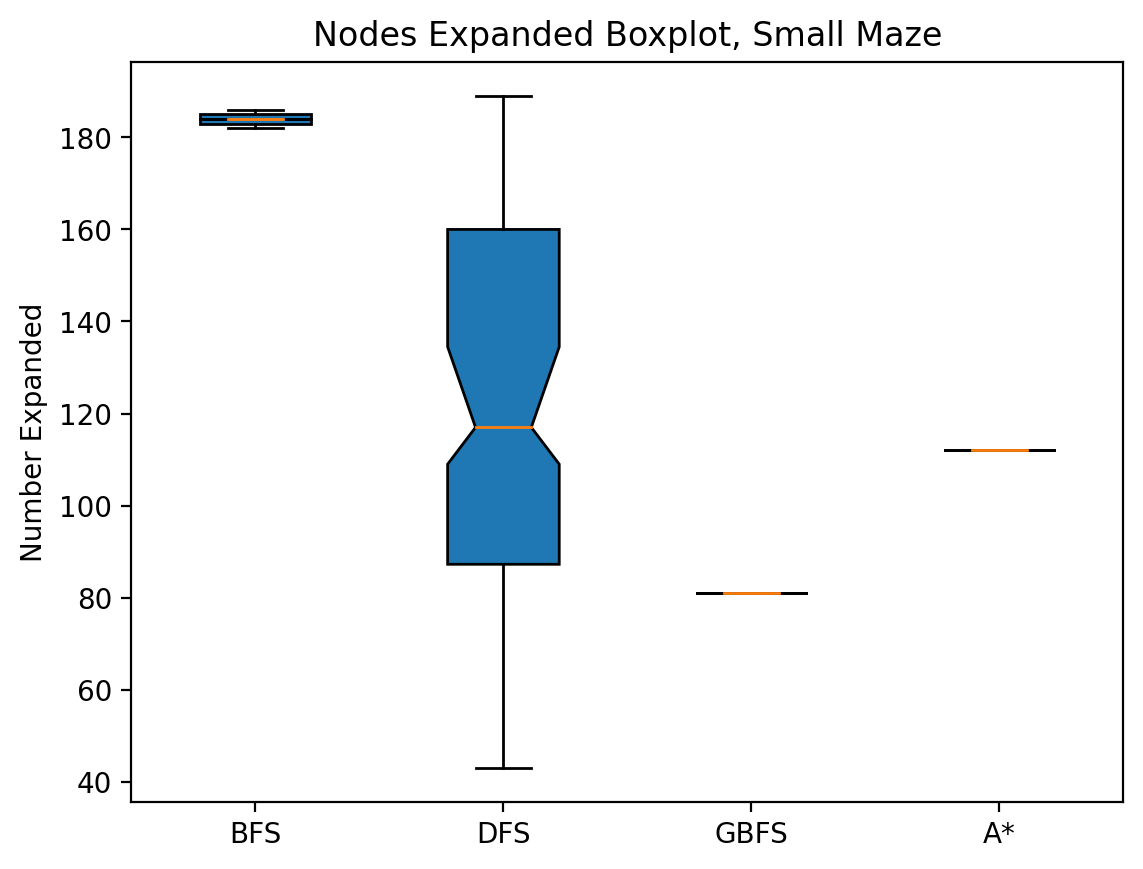

In [36]:
bplot = plt.boxplot(([bfs, dfs, gbfs, astr]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ['BFS','DFS','GBFS','A*'])  # will be used to label x-ticks
plt.ylabel("Number Expanded")
plt.title("Nodes Expanded Boxplot, Small Maze")
plt.show()

**Medium Maze**

In [37]:
bfs = []
dfs = []
gbfs = []
astr = []

# cost
for i in range(runs):
    bfs.append(med_BFS[i][0])
    dfs.append(med_DFS[i][0])
    gbfs.append(med_GBFS[i][0])
    astr.append(med_astar[i][0])

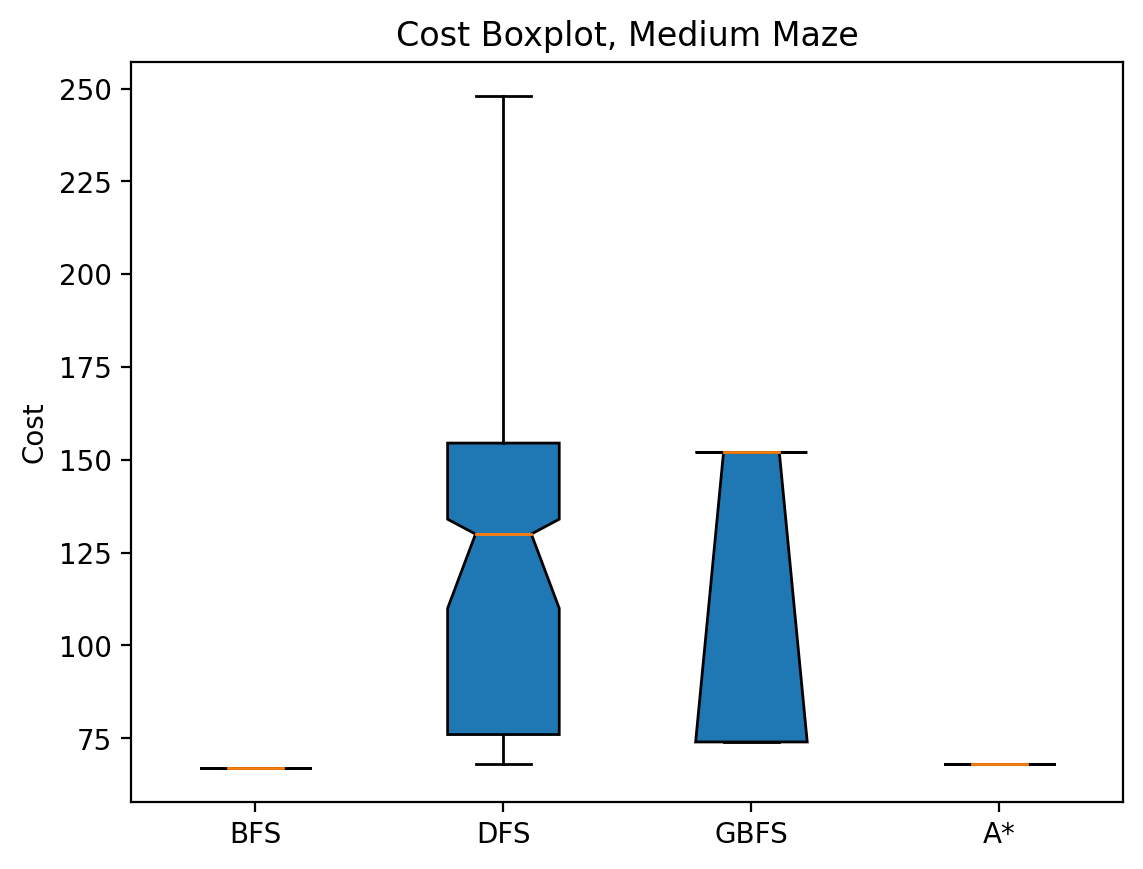

In [38]:
bplot = plt.boxplot(([bfs, dfs, gbfs, astr]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ['BFS','DFS','GBFS','A*'])  # will be used to label x-ticks
plt.ylabel("Cost")
plt.title("Cost Boxplot, Medium Maze")
plt.show()

In [39]:
bfs = []
dfs = []
gbfs = []
astr = []

# Number of Expanded Nodes
for i in range(runs):
    bfs.append(med_BFS[i][1])
    dfs.append(med_DFS[i][1])
    gbfs.append(med_GBFS[i][1])
    astr.append(med_astar[i][1])

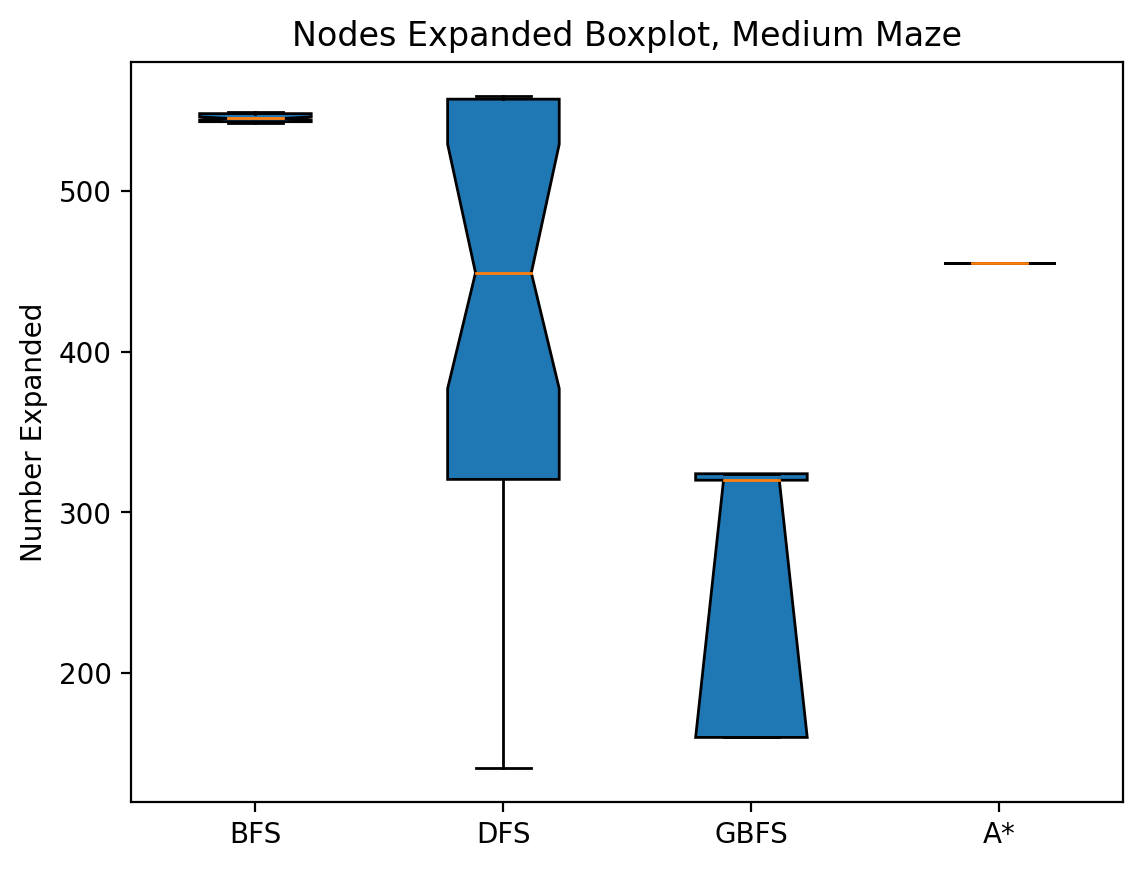

In [40]:
bplot = plt.boxplot(([bfs, dfs, gbfs, astr]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ['BFS','DFS','GBFS','A*'])  # will be used to label x-ticks
plt.ylabel("Number Expanded")
plt.title("Nodes Expanded Boxplot, Medium Maze")
plt.show()

**Large Maze**

In [41]:
bfs = []
dfs = []
gbfs = []
astr = []

# cost
for i in range(runs):
    bfs.append(lrg_BFS[i][0])
    dfs.append(lrg_DFS[i][0])
    gbfs.append(lrg_GBFS[i][0])
    astr.append(lrg_astar[i][0])

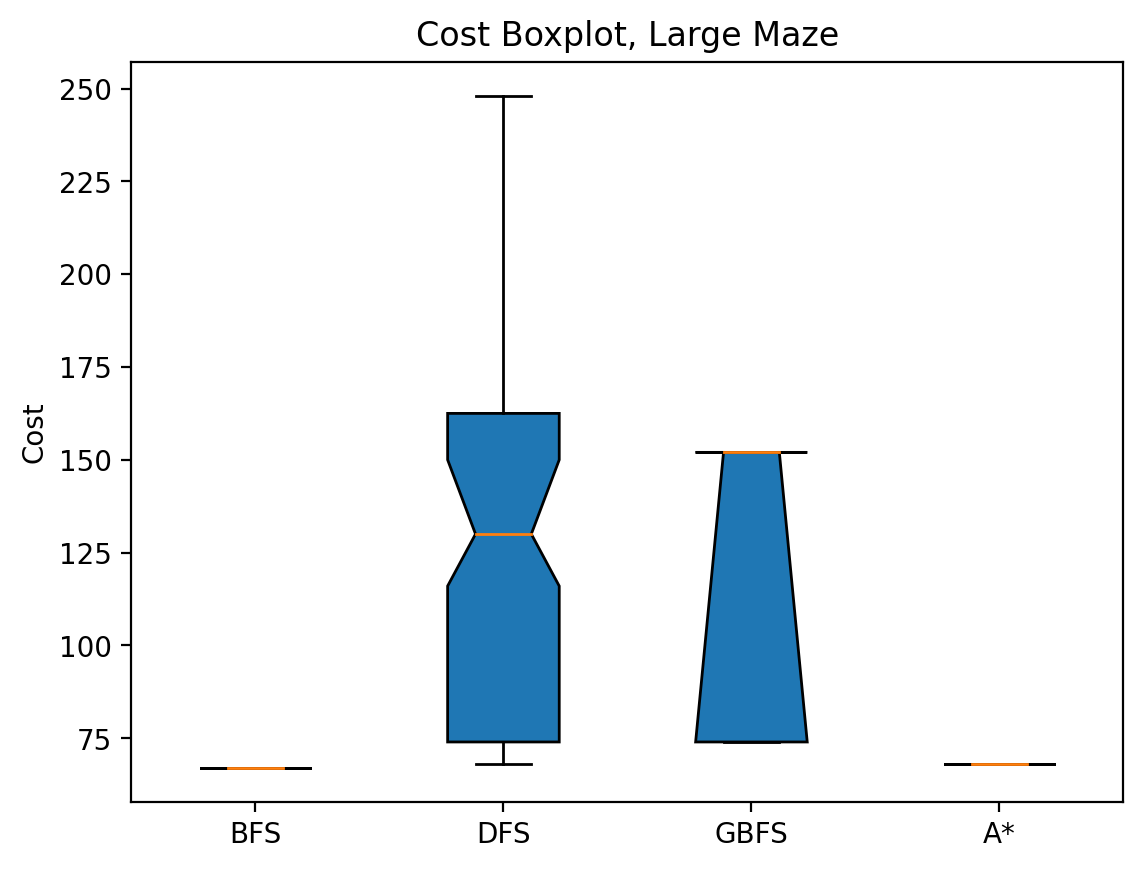

In [42]:
bplot = plt.boxplot(([bfs, dfs, gbfs, astr]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ['BFS','DFS','GBFS','A*'])  # will be used to label x-ticks
plt.ylabel("Cost")
plt.title("Cost Boxplot, Large Maze")
plt.show()

In [43]:
bfs = []
dfs = []
gbfs = []
astr = []

# cost
for i in range(runs):
    bfs.append(lrg_BFS[i][1])
    dfs.append(lrg_DFS[i][1])
    gbfs.append(lrg_GBFS[i][1])
    astr.append(lrg_astar[i][1])

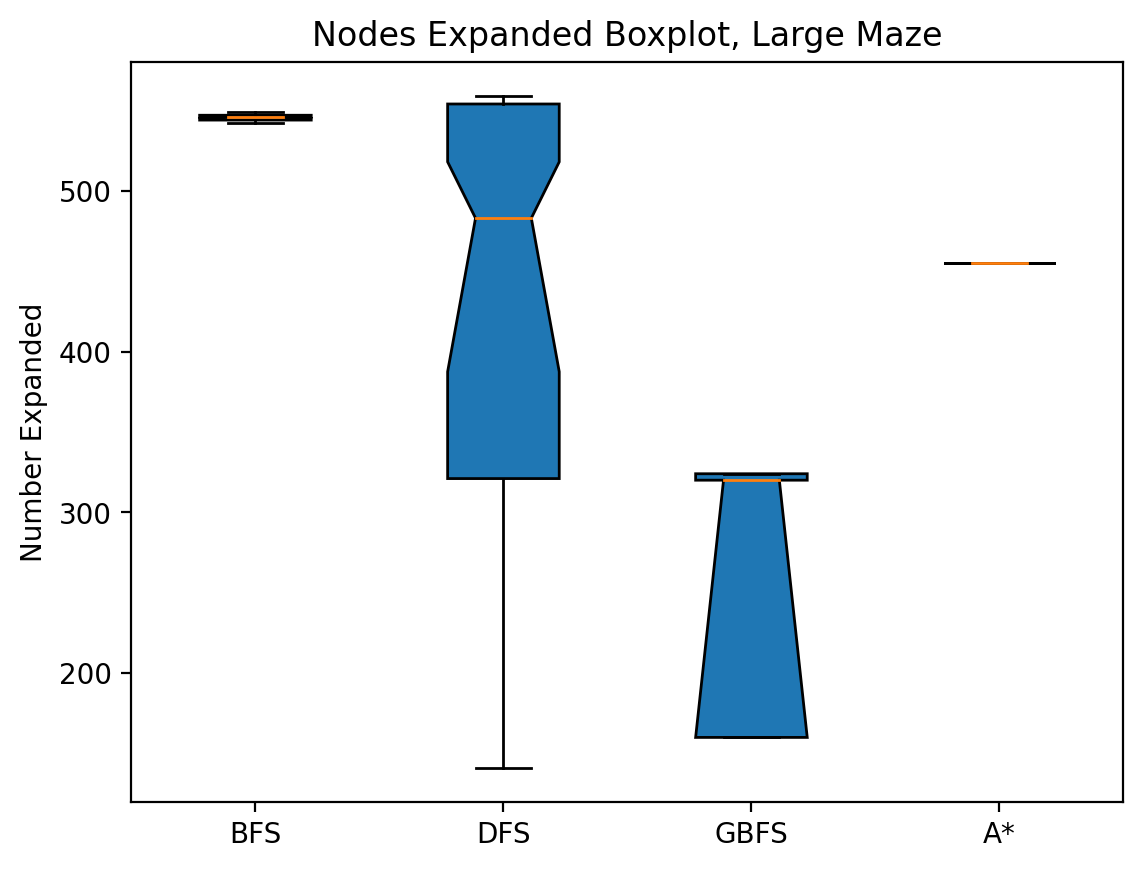

In [44]:
bplot = plt.boxplot(([bfs, dfs, gbfs, astr]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ['BFS','DFS','GBFS','A*'])  # will be used to label x-ticks
plt.ylabel("Number Expanded")
plt.title("Nodes Expanded Boxplot, Large Maze")
plt.show()

**Open Maze**

In [45]:
bfs = []
dfs = []
gbfs = []
astr = []

# cost
for i in range(runs):
    bfs.append(open_BFS[i][0])
    dfs.append(open_DFS[i][0])
    gbfs.append(open_GBFS[i][0])
    astr.append(open_astar[i][0])

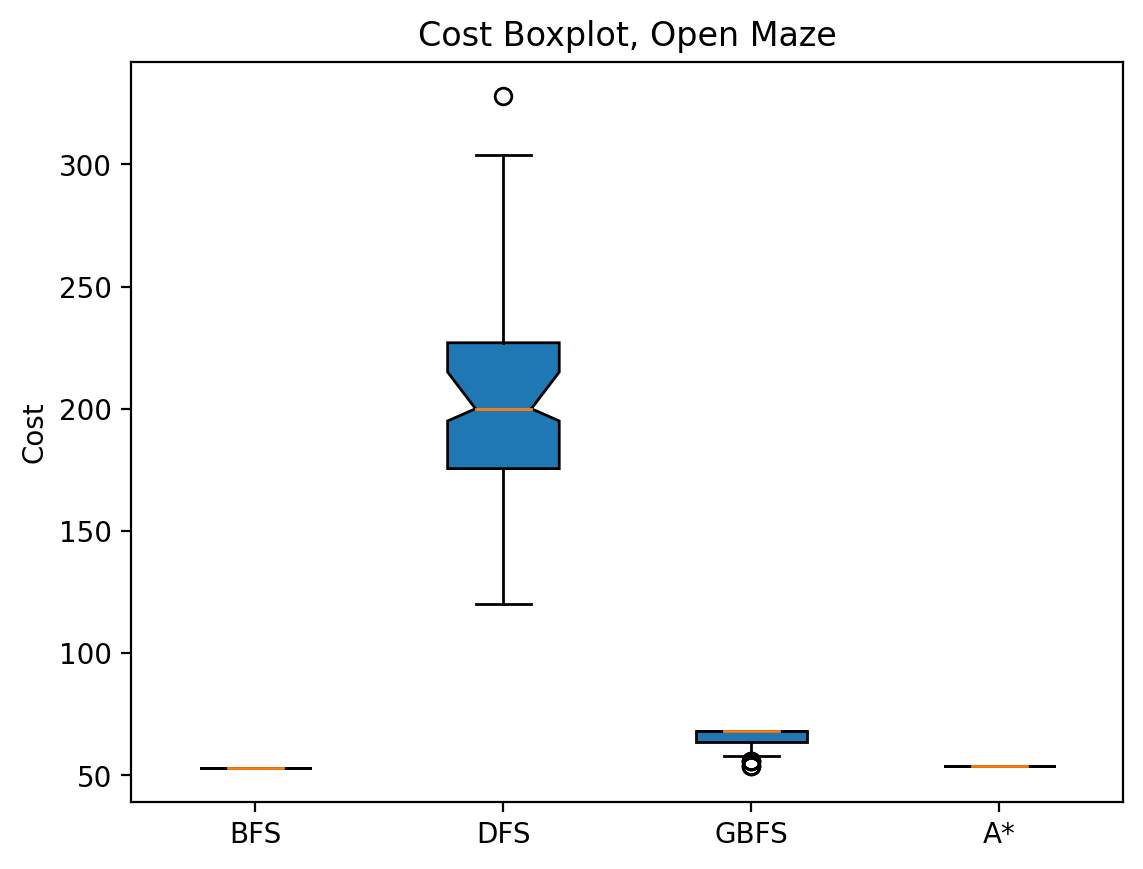

In [46]:
bplot = plt.boxplot(([bfs, dfs, gbfs, astr]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ['BFS','DFS','GBFS','A*'])  # will be used to label x-ticks
plt.ylabel("Cost")
plt.title("Cost Boxplot, Open Maze")
plt.show()

In [47]:
bfs = []
dfs = []
gbfs = []
astr = []

# cost
for i in range(runs):
    bfs.append(open_BFS[i][1])
    dfs.append(open_DFS[i][1])
    gbfs.append(open_GBFS[i][1])
    astr.append(open_astar[i][1])

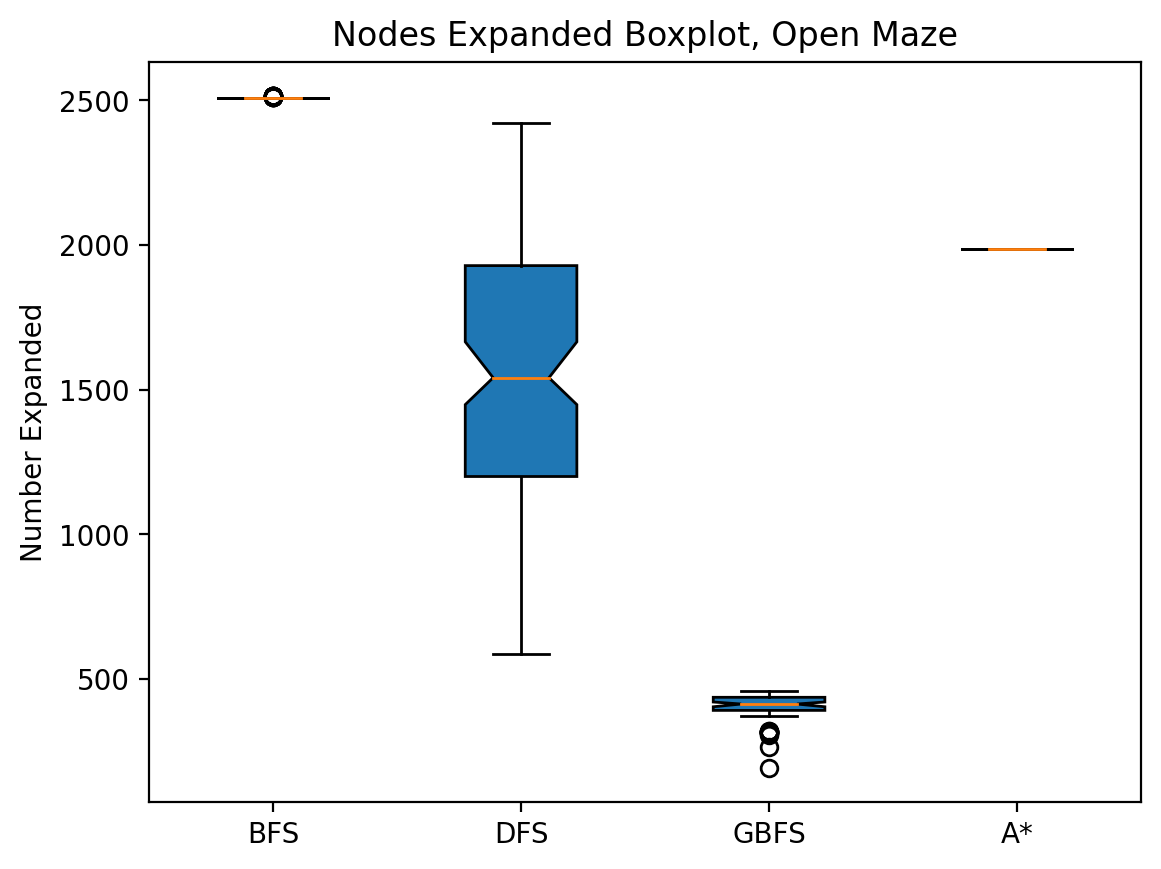

In [48]:
bplot = plt.boxplot(([bfs, dfs, gbfs, astr]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ['BFS','DFS','GBFS','A*'])  # will be used to label x-ticks
plt.ylabel("Number Expanded")
plt.title("Nodes Expanded Boxplot, Open Maze")
plt.show()

**Empty Maze**

In [49]:
bfs = []
dfs = []
gbfs = []
astr = []

# cost
for i in range(runs):
    bfs.append(e_BFS[i][0])
    dfs.append(e_DFS[i][0])
    gbfs.append(e_GBFS[i][0])
    astr.append(e_astar[i][0])

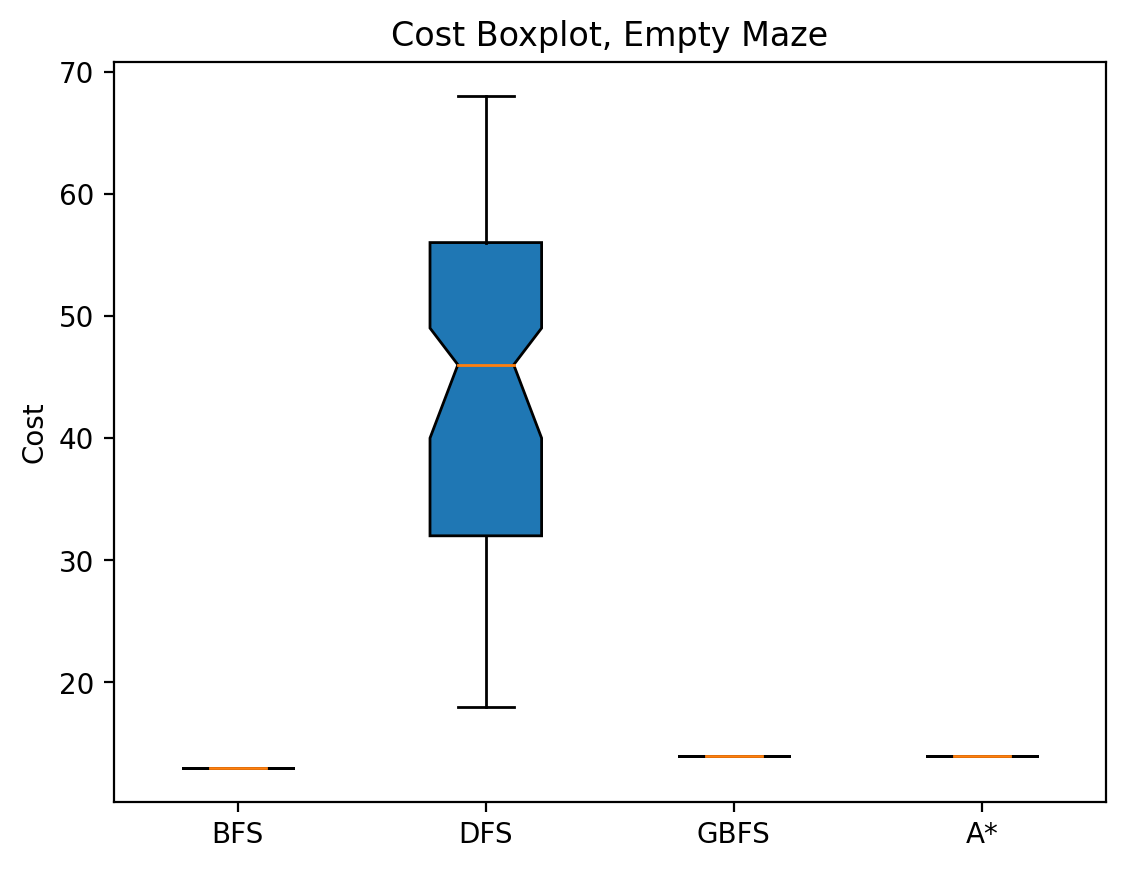

In [50]:
bplot = plt.boxplot(([bfs, dfs, gbfs, astr]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ['BFS','DFS','GBFS','A*'])  # will be used to label x-ticks
plt.ylabel("Cost")
plt.title("Cost Boxplot, Empty Maze")
plt.show()

In [51]:
bfs = []
dfs = []
gbfs = []
astr = []

# cost
for i in range(runs):
    bfs.append(e_BFS[i][1])
    dfs.append(e_DFS[i][1])
    gbfs.append(e_GBFS[i][1])
    astr.append(e_astar[i][1])

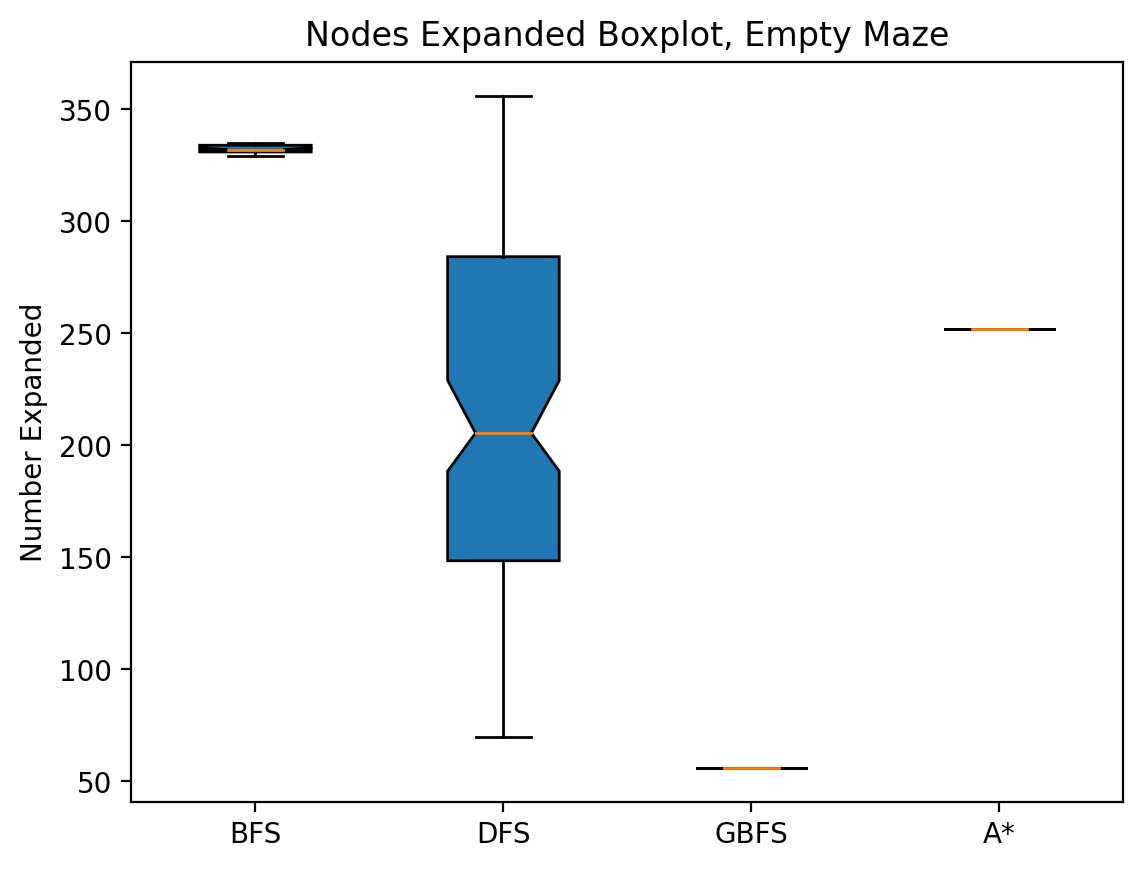

In [52]:
bplot = plt.boxplot(([bfs, dfs, gbfs, astr]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ['BFS','DFS','GBFS','A*'])  # will be used to label x-ticks
plt.ylabel("Number Expanded")
plt.title("Nodes Expanded Boxplot, Empty Maze")
plt.show()

**Empty Maze 2**

In [53]:
bfs = []
dfs = []
gbfs = []
astr = []

# cost
for i in range(runs):
    bfs.append(e2_BFS[i][0])
    dfs.append(e2_DFS[i][0])
    gbfs.append(e2_GBFS[i][0])
    astr.append(e2_astar[i][0])

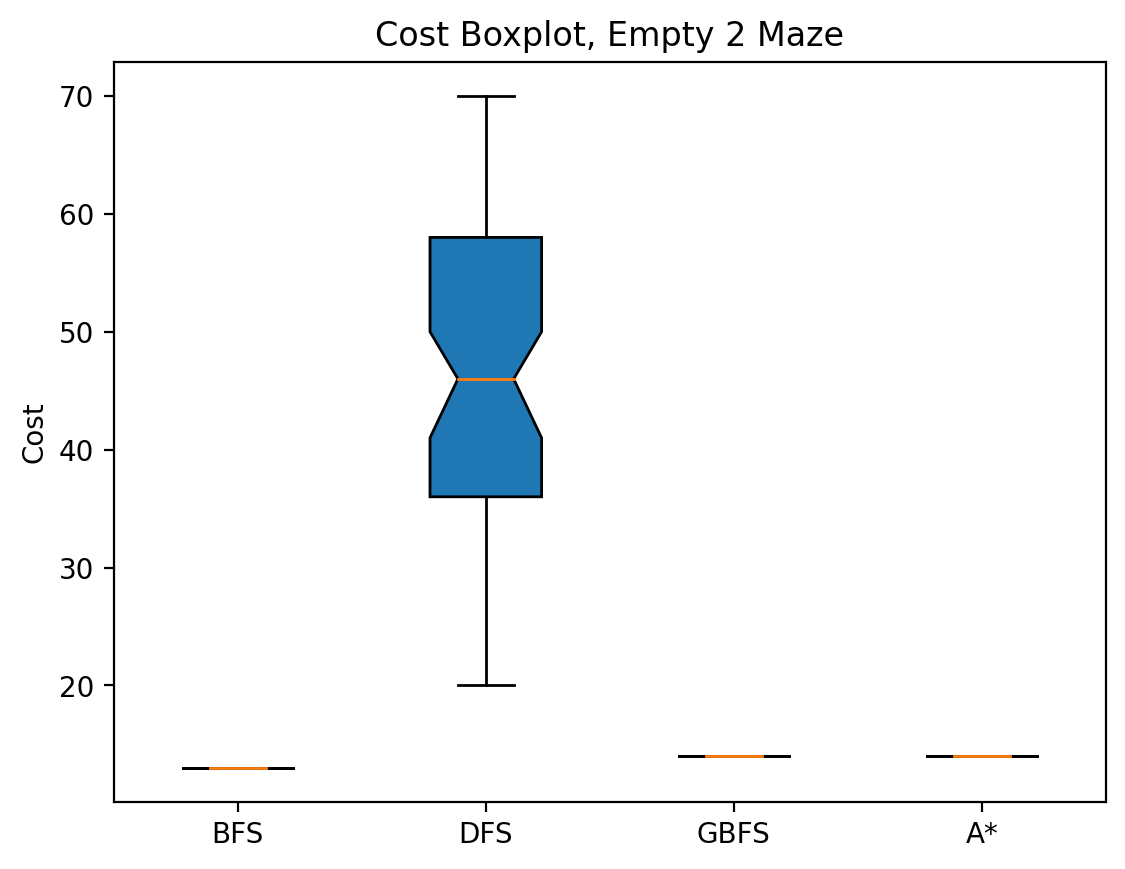

In [54]:
bplot = plt.boxplot(([bfs, dfs, gbfs, astr]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ['BFS','DFS','GBFS','A*'])  # will be used to label x-ticks
plt.ylabel("Cost")
plt.title("Cost Boxplot, Empty 2 Maze")
plt.show()

In [55]:
bfs = []
dfs = []
gbfs = []
astr = []

# cost
for i in range(runs):
    bfs.append(e2_BFS[i][1])
    dfs.append(e2_DFS[i][1])
    gbfs.append(e2_GBFS[i][1])
    astr.append(e2_astar[i][1])

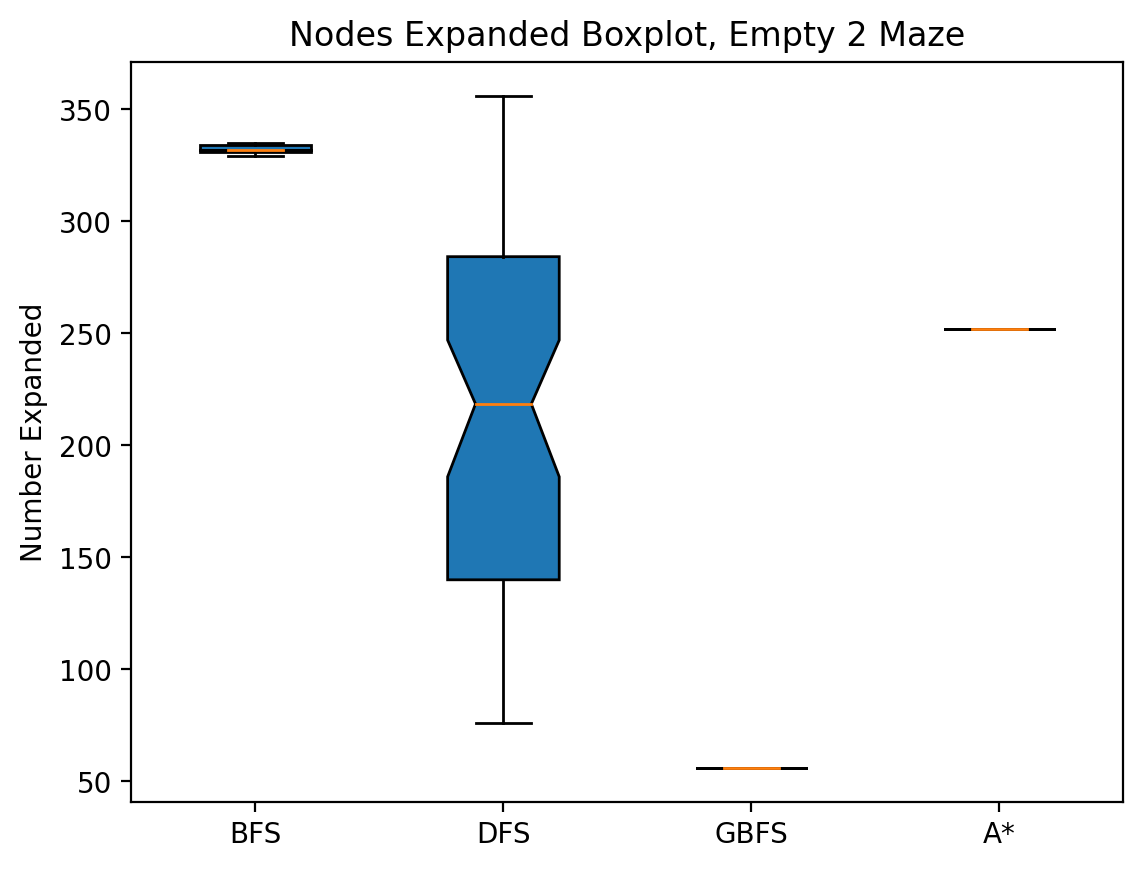

In [56]:
bplot = plt.boxplot(([bfs, dfs, gbfs, astr]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ['BFS','DFS','GBFS','A*'])  # will be used to label x-ticks
plt.ylabel("Number Expanded")
plt.title("Nodes Expanded Boxplot, Empty 2 Maze")
plt.show()

**Wall Maze**

In [57]:
bfs = []
dfs = []
gbfs = []
astr = []

# cost
for i in range(runs):
    bfs.append(wall_BFS[i][0])
    dfs.append(wall_DFS[i][0])
    gbfs.append(wall_GBFS[i][0])
    astr.append(wall_astar[i][0])

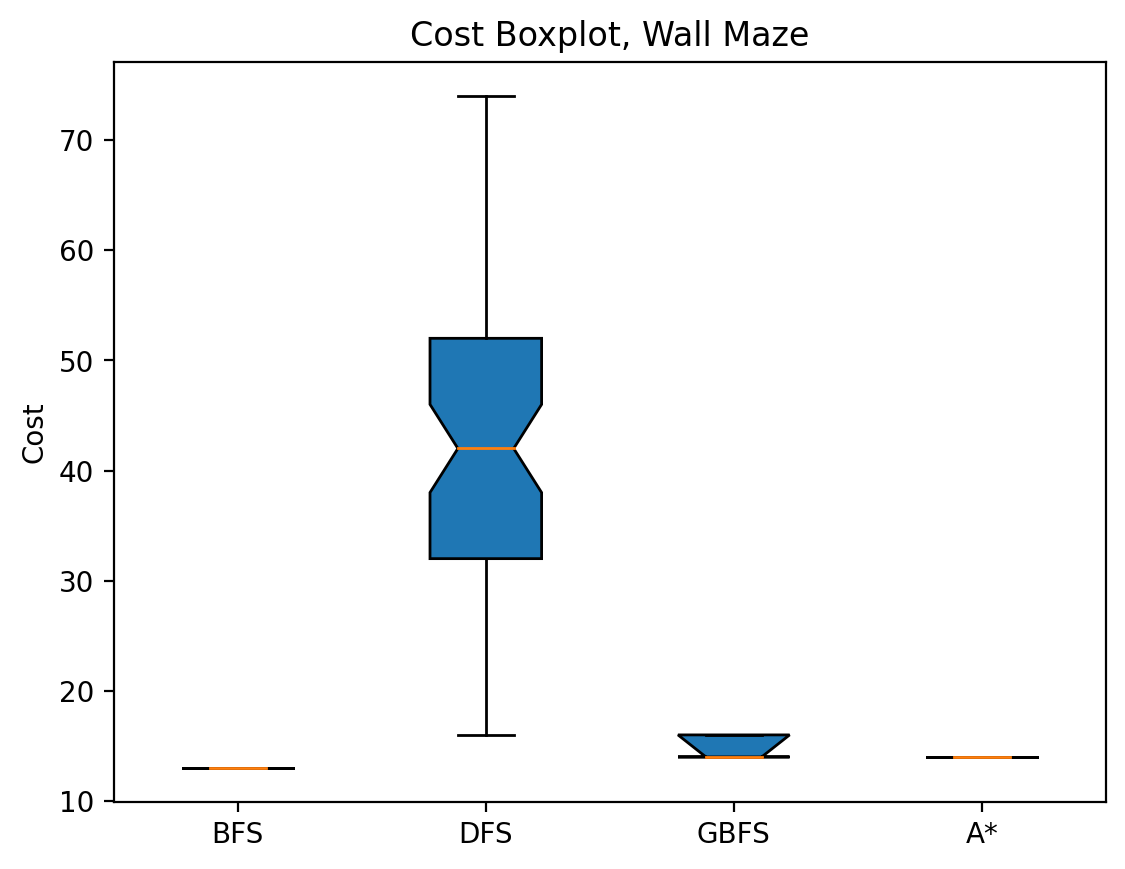

In [58]:
bplot = plt.boxplot(([bfs, dfs, gbfs, astr]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ['BFS','DFS','GBFS','A*'])  # will be used to label x-ticks
plt.ylabel("Cost")
plt.title("Cost Boxplot, Wall Maze")
plt.show()

In [59]:
bfs = []
dfs = []
gbfs = []
astr = []

# cost
for i in range(runs):
    bfs.append(wall_BFS[i][1])
    dfs.append(wall_DFS[i][1])
    gbfs.append(wall_GBFS[i][1])
    astr.append(wall_astar[i][1])

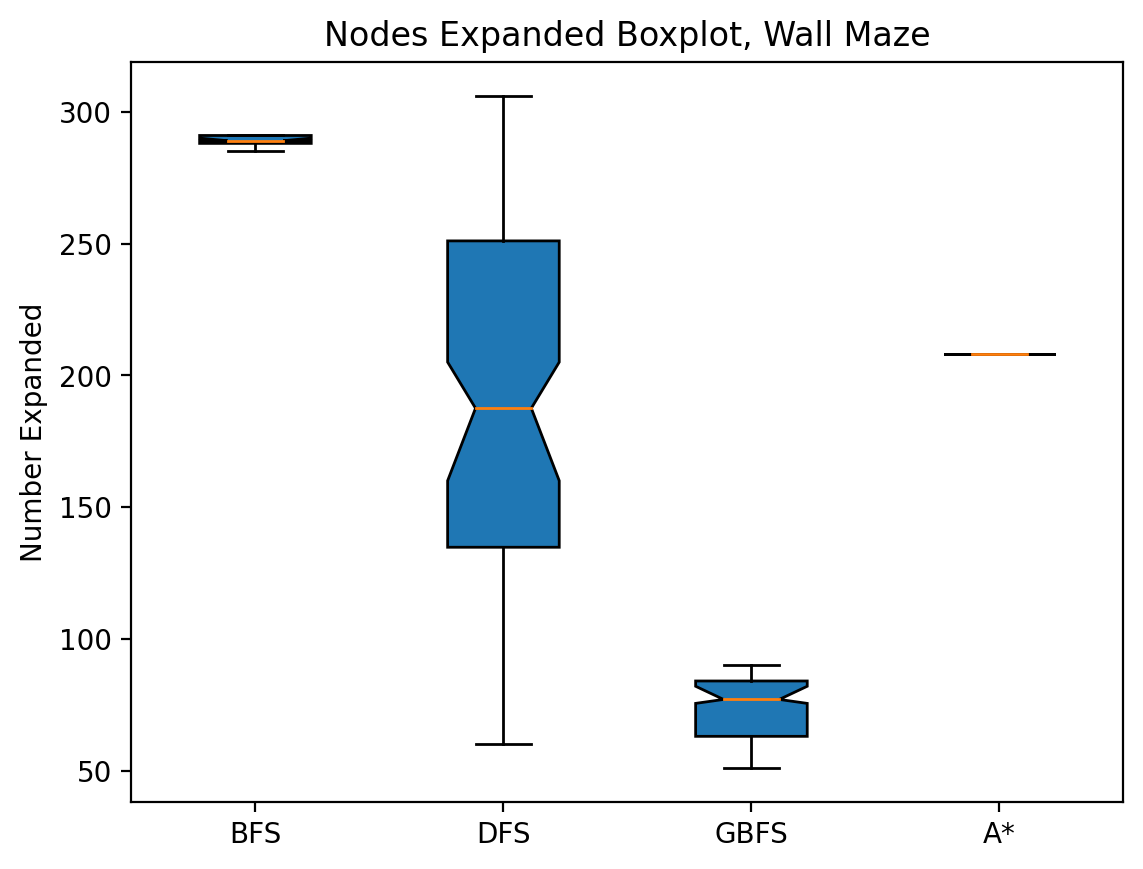

In [60]:
bplot = plt.boxplot(([bfs, dfs, gbfs, astr]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ['BFS','DFS','GBFS','A*'])  # will be used to label x-ticks
plt.ylabel("Number Expanded")
plt.title("Nodes Expanded Boxplot, Wall Maze")
plt.show()

**Loop Maze**

In [61]:
bfs = []
dfs = []
gbfs = []
astr = []

# cost
for i in range(runs):
    bfs.append(l_BFS[i][0])
    dfs.append(l_DFS[i][0])
    gbfs.append(l_GBFS[i][0])
    astr.append(l_astar[i][0])

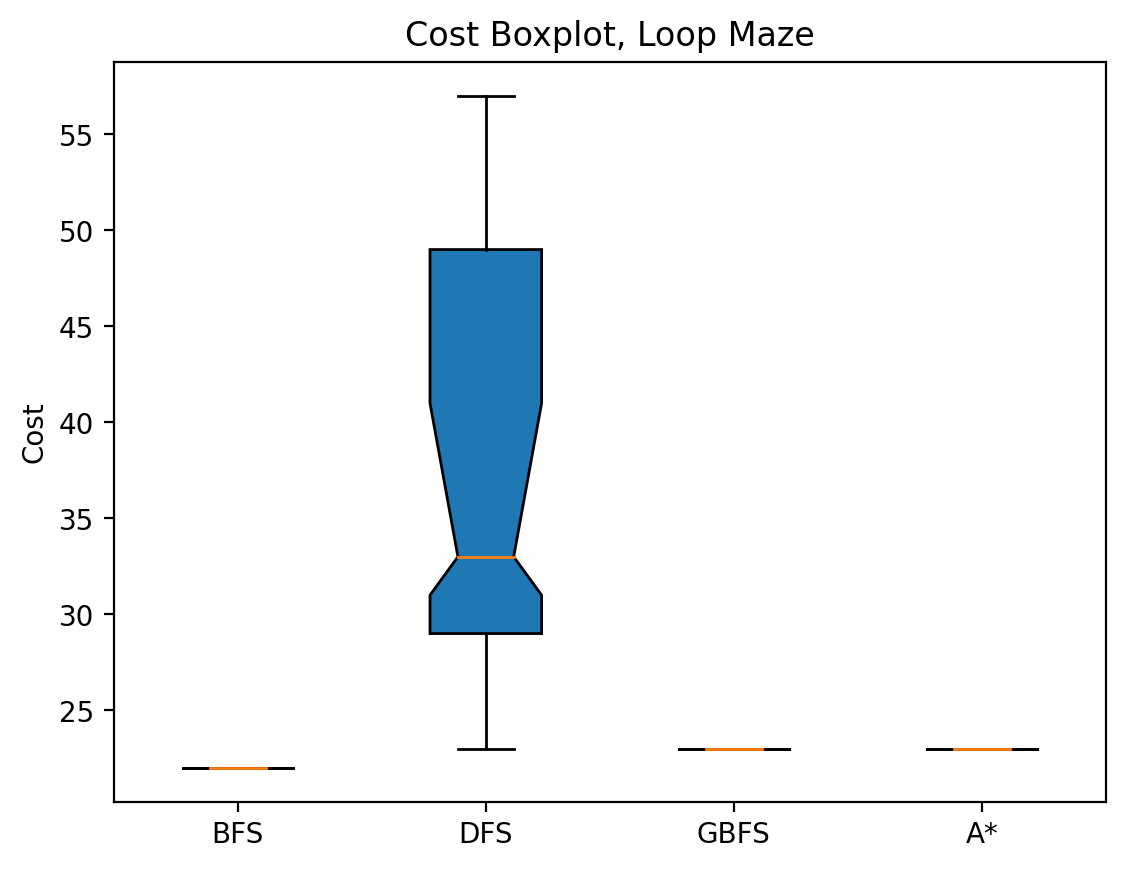

In [62]:
bplot = plt.boxplot(([bfs, dfs, gbfs, astr]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ['BFS','DFS','GBFS','A*'])  # will be used to label x-ticks
plt.ylabel("Cost")
plt.title("Cost Boxplot, Loop Maze")
plt.show()

In [63]:
bfs = []
dfs = []
gbfs = []
astr = []

# cost
for i in range(runs):
    bfs.append(l_BFS[i][1])
    dfs.append(l_DFS[i][1])
    gbfs.append(l_GBFS[i][1])
    astr.append(l_astar[i][1])

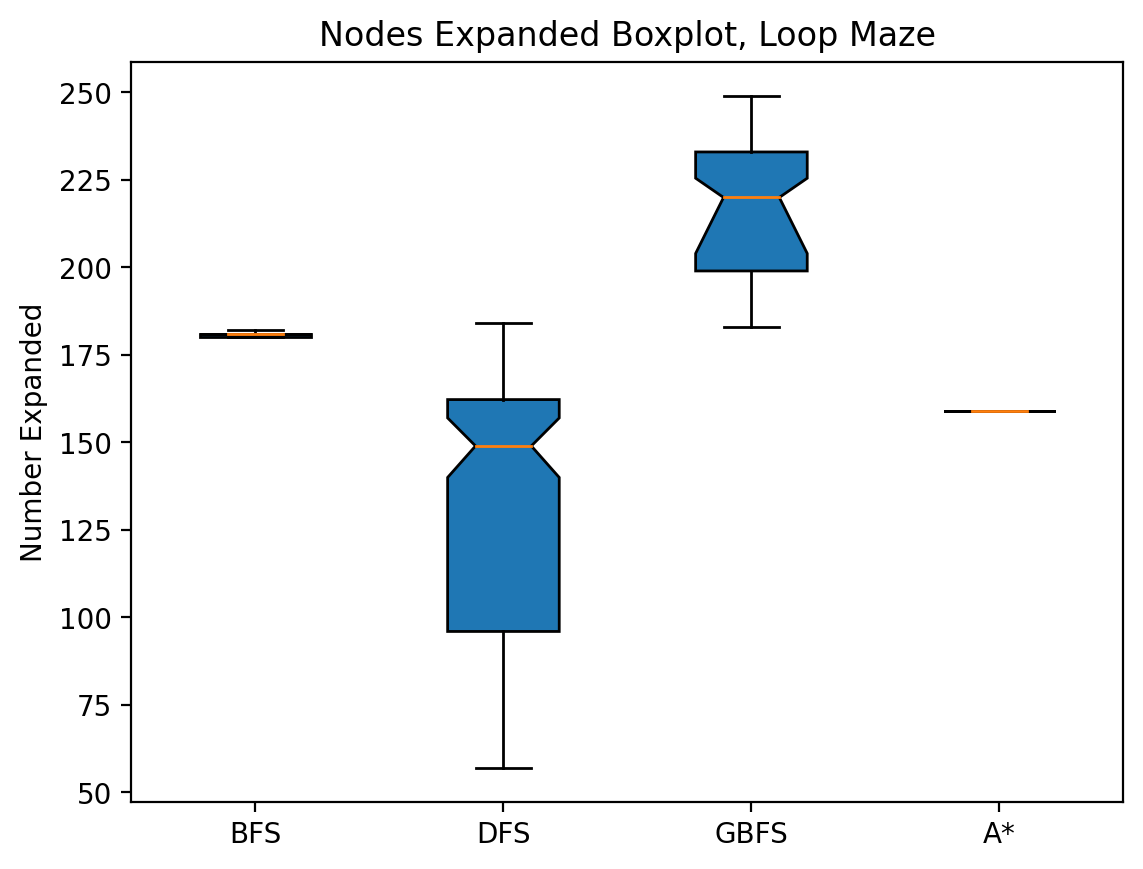

In [64]:
bplot = plt.boxplot(([bfs, dfs, gbfs, astr]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ['BFS','DFS','GBFS','A*'])  # will be used to label x-ticks
plt.ylabel("Number Expanded")
plt.title("Nodes Expanded Boxplot, Loop Maze")
plt.show()

Discuss the most important lessons you have learned from implementing the different search strategies.

I have several big takeaways after implementing the search algorithms we covered in class. BFS takes the longest and expands the most nodes on average making it the most expensive out of the search algorithms. BFS works best on smaller search spaces. DFS has the most variation in its performance. The performance of DFS depends on the architecture of the search space as well as the order of directions within that space. Additionally, GBFS and A* outperform the uninformed search algorithms. This makes sense because the informed search algorithms utilize a heuristic with knowledge of where the goal state is.

## Graduate student advanced task: IDS and Multiple goals [10 Points]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 Bonus Points].

Create a few mazes with multiple goals by adding one or two more goals to the medium size maze.
Solve the maze with your implementations for DFS, BFS, and implement in addition IDS (iterative deepening search using DFS).

Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

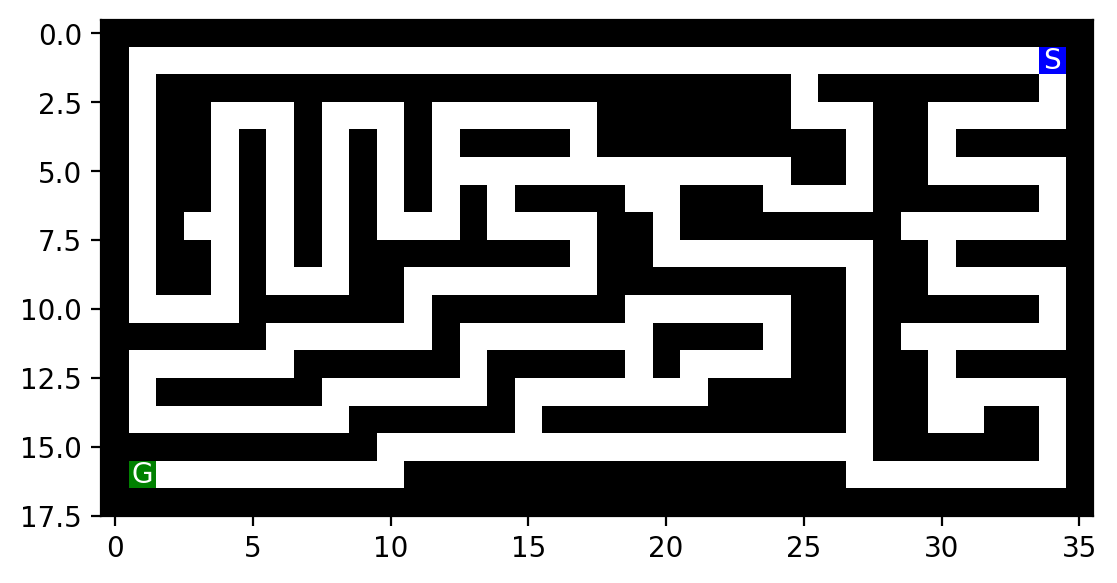

In [65]:
f = open("medium_maze.txt", "r")

maze_str = f.read()
_maze = mh.parse_maze(maze_str)
mh.show_maze(_maze)
maze1 = np.copy(_maze)


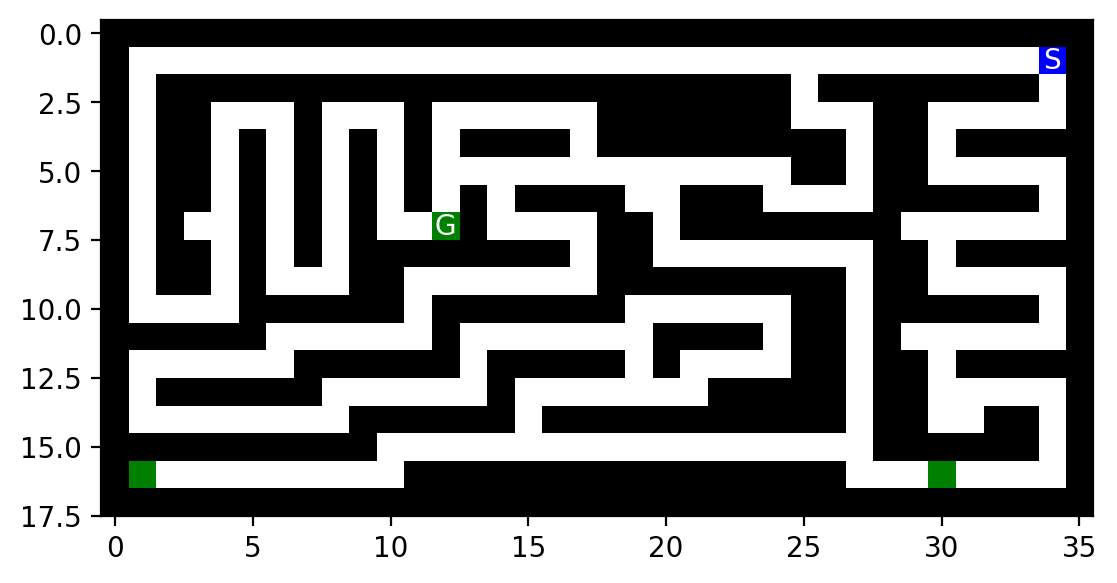

In [66]:
maze1[16,30] = 'G'
maze1[7,12] = 'G'
mh.show_maze(maze1)

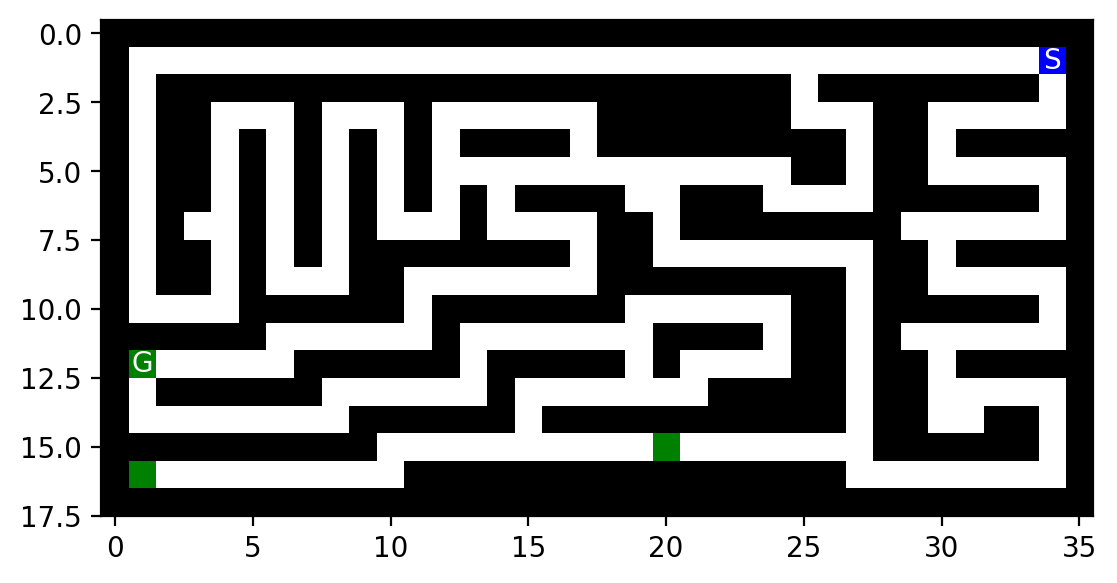

In [67]:
maze2 = np.copy(_maze)
maze2[12,1] = 'G'
maze2[15,20] = 'G'
mh.show_maze(maze2)

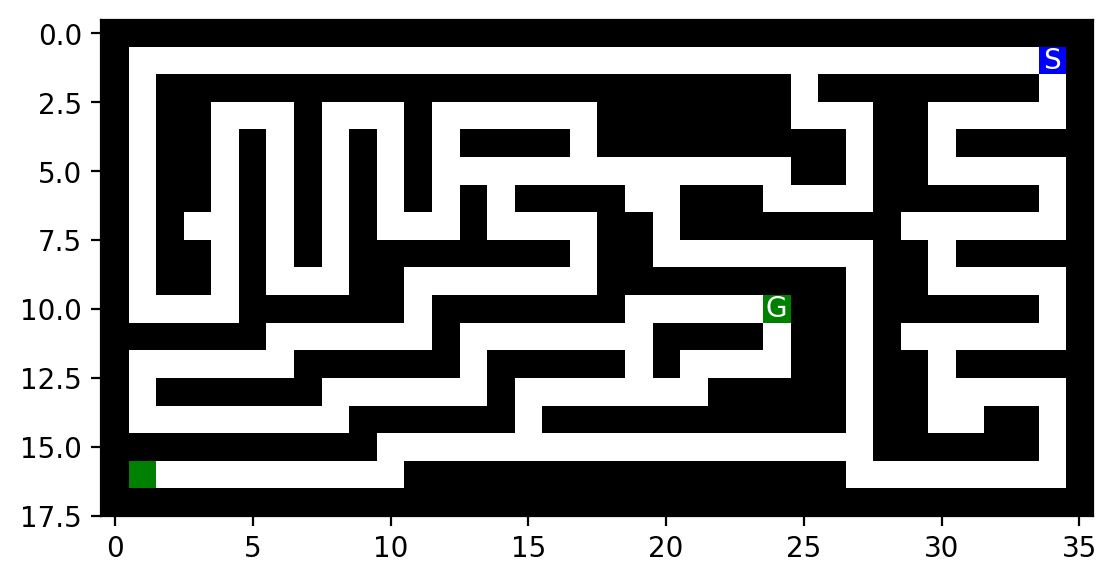

In [68]:
maze3 = np.copy(_maze)
maze3[10,24] = 'G'
mh.show_maze(maze3)

In [69]:
# Your code/answer goes here
def IDS(maze, depth = 1, anim = False, output = False, verb = False, rand = True):
    goal_found = False
    while (goal_found == False):
        result = DFS(maze, depth, anim, output, verb, rand)
        depth += 1
        if result != 'failure':
            if verb:
                return print(f'solution found at depth : {depth}')
            elif output:
                return depth
            else:
                return


In [70]:
f = open("small_maze.txt", "r")

maze_str = f.read()
maze = mh.parse_maze(maze_str)

result = IDS(maze, output = True)
print(result)

55


**Maze 1**

In [71]:
#BFS
runs = 100
avg = 0
for i in range(runs):
    result=BFS(maze1, output = True)
    avg += result[2]
avg = avg / runs
avg

35.0

In [72]:
#DFS
avg = 0
for i in range(runs):
    result=DFS(maze1,output = True)
    avg += result[2]
avg = avg / runs
avg

63.01

In [73]:
#IDS
avg = 0
for i in range(runs):
    result=IDS(maze1,output=True)
    avg += result
avg = avg / runs
avg

65.3

**Maze 2**

In [74]:
#BFS
avg = 0
for i in range(runs):
    result=BFS(maze2, output = True)
    avg += result[2]
avg = avg / runs
avg

49.0

In [75]:
#DFS
avg = 0
for i in range(runs):
    result=DFS(maze2, output = True)
    avg += result[2]
avg = avg / runs
avg

100.2

In [76]:
#IDS
avg = 0
for i in range(runs):
    result=IDS(maze2, output = True)
    avg += result
avg = avg / runs
avg

82.3

**Maze 3**

In [77]:
#BFS
avg = 0
for i in range(runs):
    result=BFS(maze3, output = True)
    avg += result[2]
avg = avg / runs
avg

68.0

In [78]:
#DFS
avg = 0
for i in range(runs):
    result=DFS(maze3, output = True)
    avg += result[2]
avg = avg / runs
avg

126.69

In [79]:
avg = 0
for i in range(runs):
    result=IDS(maze3, output = True)
    avg += result
avg = avg / runs
avg

112.05

__Discussion__

There are some interesting findings afer running an experiment comparing the depth reached for BFS, DFS, and IDS with the multigoal mazes. BFS finds the first goal at a lesser depth than the other two algorithms. However, as we have learned, BFS is expensive to implement since it requires high storage and high run time. Conversely, DFS finds the first goal at a higher depth, but DFS does not have the same high storage cost that BFS has. The middle ground between these two algorithms is IDS since it iterates through paths at each depth until a solution is found. Therefore, it finds the solution at a lesser depth than DFS while also not having the same large storage requirements as BFS.

## More advanced tasks to think about

Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [80]:
# Your code/answer goes here

Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [81]:
# Your code/answer goes here

What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [82]:
# Your code/answer goes here